<a href="https://colab.research.google.com/github/abd-RAHEEM/ATLAS-GAME/blob/main/ATLAS_GAME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT AND SETUP**

In [19]:
import pandas as pd
import re
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain # Louvain algorithm for Task 2
from typing import List, Set, Tuple, Dict,Optional
import logging
import warnings
from matplotlib.lines import Line2D
import seaborn as sns

**DATA LOADING AND CLEANING**

In [2]:
countries = pd.read_csv("countries.csv")
cities = pd.read_csv("cities.csv")

print("Countries shape:", countries.shape)
print("Cities shape:", cities.shape)

print(countries.head())
print(cities.head())


Countries shape: (195, 1)
Cities shape: (500, 1)
   country_name
0  Afghanistan 
1      Albania 
2       Algeria
3       Andorra
4        Angola
   city_name
0      Tokyo
1    Jakarta
2      Delhi
3  Guangzhou
4     Mumbai


In [3]:
countries.isnull().sum(), cities.isnull().sum()


(country_name    0
 dtype: int64,
 city_name    0
 dtype: int64)

In [4]:
print(countries.info())
print(cities.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_name  195 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city_name  500 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB
None


In [5]:
def clean_name(name):
    name = name.lower()
    # remove parenthetical text
    name = re.sub(r"\s*\(.*?\)", "", name)
    # keep only letters
    name = re.sub(r"[^a-z]", "", name)
    return name


In [6]:
countries["clean_name"] = countries["country_name"].apply(clean_name)
cities["clean_name"] = cities["city_name"].apply(clean_name)


In [7]:
print(countries['clean_name'].nunique())
print(cities['clean_name'].nunique())

195
500


In [8]:
countries.head(5)
cities.head(5)


city_name clean_name
0      Tokyo      tokyo
1    Jakarta    jakarta
2      Delhi      delhi
3  Guangzhou  guangzhou
4     Mumbai     mumbai

In [9]:
countries = countries.drop_duplicates(subset="clean_name")
cities = cities.drop_duplicates(subset="clean_name")

print("Countries after dedup:", len(countries))
print("Cities after dedup:", len(cities))


Countries after dedup: 195
Cities after dedup: 500


In [10]:
country_names = countries["clean_name"].tolist()
city_names = cities["clean_name"].tolist()

combined_names = list(set(country_names + city_names))


In [11]:
first_letters = Counter(name[0] for name in country_names)
last_letters = Counter(name[-1] for name in country_names)

first_letters.most_common(10), last_letters.most_common(10)

([('s', 26),
  ('m', 18),
  ('b', 17),
  ('c', 17),
  ('a', 11),
  ('g', 11),
  ('n', 11),
  ('t', 11),
  ('p', 10),
  ('l', 9)],
 [('a', 74),
  ('n', 24),
  ('s', 18),
  ('e', 16),
  ('o', 11),
  ('i', 8),
  ('d', 8),
  ('y', 7),
  ('r', 6),
  ('u', 6)])

In [12]:
countries[["clean_name"]].to_csv("countries_cleaned.csv", index=False)
cities[["clean_name"]].to_csv("cities_cleaned.csv", index=False)


In [13]:
# Load and clean data
countries = pd.read_csv('countries_cleaned.csv')['clean_name'].tolist()
cities = pd.read_csv('cities_cleaned.csv')['clean_name'].tolist()

def create_atlas_graph(word_list):
    """
    Creates a Directed Graph where an edge A -> B exists
    if word B starts with the last letter of word A.
    """
    G = nx.DiGraph()
    G.add_nodes_from(word_list)

    # Efficient edge creation: group words by their starting letter
    starting_map = {}
    for word in word_list:
        start_char = word[0].lower()
        starting_map.setdefault(start_char, []).append(word)

    for word in word_list:
        last_char = word[-1].lower()
        if last_char in starting_map:
            for target in starting_map[last_char]:
                if word != target: # Prevent self-loops in simple atlas
                    G.add_edge(word, target)
    return G

# Create the 3 required graphs
G_country = create_atlas_graph(countries)
G_city = create_atlas_graph(cities[:500]) # 500 most populated
G_combined = create_atlas_graph(list(set(countries + cities[:500])))

print(f"Graphs Created: \nCountry: {G_country.number_of_nodes()} nodes\n"
      f"City: {G_city.number_of_nodes()} nodes\n"
      f"Combined: {G_combined.number_of_nodes()} nodes")

Graphs Created: 
Country: 195 nodes
City: 500 nodes
Combined: 694 nodes


**GRAPH CONSTRUCTION**

In [20]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class AtlasGraphBuilder:
    """Build and manage Atlas game graphs"""

    def __init__(self):
        self.graphs = {}
        self.node_data = {}

    def load_data(self, countries_file: str, cities_file: str) -> Tuple[List[str], List[str]]:
        """
        Load country and city data from CSV files

        Args:
            countries_file: Path to countries CSV
            cities_file: Path to cities CSV

        Returns:
            Tuple of (countries list, cities list)
        """
        try:
            # Load countries
            countries_df = pd.read_csv(countries_file)
            countries = countries_df['clean_name'].tolist()
            logger.info(f"Loaded {len(countries)} countries")

            # Load cities
            cities_df = pd.read_csv(cities_file)
            cities = cities_df['clean_name'].tolist()
            logger.info(f"Loaded {len(cities)} cities")

            return countries, cities

        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise

    def build_atlas_graph(self, places: List[str], graph_name: str = "atlas") -> nx.DiGraph:
        """
        Build directed atlas game graph

        Args:
            places: List of place names
            graph_name: Name identifier for the graph

        Returns:
            NetworkX DiGraph with atlas game edges
        """
        G = nx.DiGraph()
        G.graph['name'] = graph_name

        # Add all places as nodes
        for place in places:
            G.add_node(place)

        # Add edges: A -> B if B starts with A's last letter
        edges_count = 0
        for place_a in places:
            last_letter = place_a[-1].lower()

            for place_b in places:
                if place_a != place_b and place_b[0].lower() == last_letter: # Corrected condition
                    G.add_edge(place_a, place_b)
                    edges_count += 1

        logger.info(f"Built {graph_name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        self.graphs[graph_name] = G
        return G

    def get_graph_stats(self, graph: nx.DiGraph) -> Dict:
        """Get basic statistics about the graph"""
        stats = {
            'num_nodes': graph.number_of_nodes(),
            'num_edges': graph.number_of_edges(),
            'density': nx.density(graph),
            'num_sccs': len(list(nx.strongly_connected_components(graph))),
            'num_trap_nodes': len([n for n, d in graph.out_degree() if d == 0]),
            'num_source_nodes': len([n for n, d in graph.in_degree() if d == 0]),
            'avg_out_degree': sum(dict(graph.out_degree()).values()) / graph.number_of_nodes(),
            'avg_in_degree': sum(dict(graph.in_degree()).values()) / graph.number_of_nodes(),
        }
        return stats

    def print_graph_stats(self, graph: nx.DiGraph, name: str = None):
        """Print formatted graph statistics"""
        if name is None:
            name = graph.graph.get('name', 'Graph')

        stats = self.get_graph_stats(graph)

        print(f"\n{'='*60}")
        print(f"GRAPH STATISTICS: {name.upper()}")
        print(f"{'='*60}")
        print(f"Nodes: {stats['num_nodes']}")
        print(f"Edges: {stats['num_edges']}")
        print(f"Density: {stats['density']:.6f}")
        print(f"Strongly Connected Components: {stats['num_sccs']}")
        print(f"Trap Nodes (out-degree=0): {stats['num_trap_nodes']}")
        print(f"Source Nodes (in-degree=0): {stats['num_source_nodes']}")
        print(f"Avg Out-Degree: {stats['avg_out_degree']:.2f}")
        print(f"Avg In-Degree: {stats['avg_in_degree']:.2f}")
        print(f"{'='*60}\n")

    def find_trap_nodes(self, graph: nx.DiGraph) -> List[str]:
        """Find nodes with no outgoing edges (losing positions)"""
        return [n for n, d in graph.out_degree() if d == 0]

    def find_source_nodes(self, graph: nx.DiGraph) -> List[str]:
        """Find nodes with no incoming edges (perfect starting points)"""
        return [n for n, d in graph.in_degree() if d == 0]


if __name__ == "__main__":
    builder = AtlasGraphBuilder()
    countries, cities = builder.load_data('countries_cleaned.csv', 'cities_cleaned.csv')

    G_countries = builder.build_atlas_graph(countries, "Countries Only")
    G_cities = builder.build_atlas_graph(cities, "Cities Only")
    G_combined = builder.build_atlas_graph(countries + cities, "Countries + Cities")

    builder.print_graph_stats(G_countries, "Countries")
    builder.print_graph_stats(G_cities, "Cities")
    builder.print_graph_stats(G_combined, "Combined")


GRAPH STATISTICS: COUNTRIES
Nodes: 195
Edges: 2036
Density: 0.053820
Strongly Connected Components: 43
Trap Nodes (out-degree=0): 0
Source Nodes (in-degree=0): 38
Avg Out-Degree: 10.44
Avg In-Degree: 10.44


GRAPH STATISTICS: CITIES
Nodes: 500
Edges: 7590
Density: 0.030421
Strongly Connected Components: 63
Trap Nodes (out-degree=0): 0
Source Nodes (in-degree=0): 62
Avg Out-Degree: 15.18
Avg In-Degree: 15.18


GRAPH STATISTICS: COMBINED
Nodes: 694
Edges: 18035
Density: 0.037499
Strongly Connected Components: 70
Trap Nodes (out-degree=0): 0
Source Nodes (in-degree=0): 69
Avg Out-Degree: 25.99
Avg In-Degree: 25.99



**VISUALIZATION FUNCTIONS**

In [21]:
"""
PRECOG Atlas Game - Advanced Visualization Module
Creates beautiful, publication-quality graph visualizations
"""



# Import Line2D for custom legend handles
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore')
logger = logging.getLogger(__name__)


class AtlasVisualizer:
    """Advanced visualization for Atlas game graphs"""

    def __init__(self, figsize: Tuple[int, int] = (20, 16)):
        self.figsize = figsize
        self.color_palette = {
            'node_high': '#2E86AB',
            'node_med': '#A23B72',
            'node_low': '#F18F01',
            'edge': '#CCCCCC',
            'edge_highlight': '#FF6B6B',
            'background': '#FAFAFA'
        }

    def optimize_layout_spring(self,
                               graph: nx.DiGraph,
                               k: float = 0.5,
                               iterations: int = 50,
                               scale: float = 1.0,
                               seed: int = 42) -> Dict:
        """Optimized spring/force-directed layout"""
        n = len(graph)

        if n > 300:
            k = max(k, 2.0)
            iterations = max(iterations, 100)

        logger.info(f"Computing spring layout (k={k}, iter={iterations}) for {n} nodes")

        pos = nx.spring_layout(
            graph,
            k=k,
            iterations=iterations,
            seed=seed,
            scale=scale,
            weight='weight'
        )

        return pos

    def filter_edges_by_importance(self,
                                    graph: nx.DiGraph,
                                    percentile: float = 70.0) -> Tuple[List, nx.DiGraph]:
        """Filter edges to show only top percentile by importance"""
        all_edge_data = []  # Store (u, v, importance)
        numerical_importances = []  # Store only importance values

        for u, v in graph.edges():
            out_u = graph.out_degree(u)
            in_v = graph.in_degree(v)
            importance = min(out_u, in_v)
            all_edge_data.append((u, v, importance))
            numerical_importances.append(importance)

        if not numerical_importances:  # Handle case of no edges
            return [], graph.copy()

        # Calculate threshold on numerical importances
        threshold = np.percentile(numerical_importances, percentile)

        # Filter all_edge_data based on the threshold
        filtered_edges_data = [(u, v, imp) for u, v, imp in all_edge_data if imp >= threshold]
        filtered_edges_list = [(u, v) for u, v, _ in filtered_edges_data]

        logger.info(f"Filtered edges: {len(filtered_edges_list)}/{graph.number_of_edges()} kept")

        G_filtered = graph.copy()
        # Remove edges that are *below* the threshold
        edges_to_remove = [(u, v) for u, v, imp in all_edge_data if imp < threshold]
        G_filtered.remove_edges_from(edges_to_remove)

        return filtered_edges_list, G_filtered

    def get_node_sizes(self, graph: nx.DiGraph,
                       base_size: float = 50,
                       scale_by: str = 'degree') -> Dict[str, float]:
        """Compute node sizes for visualization"""
        if scale_by == 'degree':
            values = dict(graph.degree())
        elif scale_by == 'out_degree':
            values = dict(graph.out_degree())
        elif scale_by == 'in_degree':
            values = dict(graph.in_degree())
        else:
            raise ValueError(f"Unknown scale_by: {scale_by}")

        min_val = min(values.values())
        max_val = max(values.values())

        if max_val == min_val:
            return {n: base_size for n in graph.nodes()}

        sizes = {}
        for node, val in values.items():
            normalized = (val - min_val) / (max_val - min_val)
            sizes[node] = base_size + normalized * (base_size * 2)

        return sizes

    def get_node_colors(self, graph: nx.DiGraph,
                        metric: str = 'in_degree') -> Tuple[List, str]:
        """Compute node colors based on metric"""
        if metric == 'in_degree':
            values = [graph.in_degree(n) for n in graph.nodes()]
            cmap = 'RdYlGn_r'
        elif metric == 'out_degree':
            values = [graph.out_degree(n) for n in graph.nodes()]
            cmap = 'RdYlGn'
        else:
            raise ValueError(f"Unknown metric: {metric}")

        return values, cmap

    def visualize_countries_graph(self,
                                  graph: nx.DiGraph,
                                  title: str = "Countries - Atlas Game",
                                  save_path: Optional[str] = None):
        """Visualize countries graph"""
        fig, ax = plt.subplots(figsize=self.figsize)

        pos = self.optimize_layout_spring(graph, k=0.5, iterations=50)

        sizes = self.get_node_sizes(graph, base_size=100, scale_by='out_degree')
        node_size_list = [sizes[n] for n in graph.nodes()]

        colors, cmap = self.get_node_colors(graph, metric='in_degree')

        nx.draw_networkx_edges(
            graph, pos,
            edge_color=self.color_palette['edge'],
            arrows=True,
            arrowsize=10,
            arrowstyle='-|>',
            width=0.5,
            alpha=0.3,
            connectionstyle='arc3,rad=0.1',
            ax=ax
        )

        nodes = nx.draw_networkx_nodes(
            graph, pos,
            node_size=node_size_list,
            node_color=colors,
            cmap=cmap,
            alpha=0.9,
            ax=ax,
            edgecolors='black',
            linewidths=0.5
        )

        nx.draw_networkx_labels(
            graph, pos,
            font_size=6,
            font_weight='bold',
            font_color='black',
            ax=ax
        )

        sm = plt.cm.ScalarMappable(cmap=cmap,
                                   norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('In-Degree (incoming edges)', rotation=270, labelpad=20)

        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved visualization to {save_path}")

        plt.show()

    def visualize_cities_graph(self,
                               graph: nx.DiGraph,
                               title: str = "Cities - Atlas Game (Enhanced)",
                               top_percentile: float = 0.0, # Show all edges now
                               save_path: Optional[str] = None):
        """Visualize cities graph with more dispersion, all labels, and dynamic edges"""
        fig, ax = plt.subplots(figsize=self.figsize)

        # Use filtering to get G_filtered, but set percentile to 0.0 to keep all edges
        _, G_filtered = self.filter_edges_by_importance(graph, percentile=top_percentile)

        logger.info(f"Visualizing {G_filtered.number_of_nodes()} nodes with {G_filtered.number_of_edges()} edges")

        # Use spring layout with parameters similar to countries for dispersion
        pos = self.optimize_layout_spring(G_filtered, k=0.7, iterations=100) # Slightly increased k and iterations

        # Node sizing based on degree
        sizes = self.get_node_sizes(G_filtered, base_size=30, scale_by='degree') # Smaller base size for cities
        node_size_list = [sizes[n] for n in G_filtered.nodes()]

        # Node coloring for cities (can be customized, keeping green for now)
        node_color = "lightgreen"

        # Calculate edge colors, alphas, and widths based on degrees for dynamic visibility
        edge_colors = []
        edge_alphas = []
        edge_widths = []

        # Get max/min degree sum for normalization
        max_degree_sum = 0
        min_degree_sum = float('inf')
        for u, v in G_filtered.edges():
            current_degree_sum = G_filtered.degree(u) + G_filtered.degree(v)
            if current_degree_sum > max_degree_sum:
                max_degree_sum = current_degree_sum
            if current_degree_sum < min_degree_sum:
                min_degree_sum = current_degree_sum

        if max_degree_sum == min_degree_sum:
            if G_filtered.number_of_edges() > 0:
                max_degree_sum += 1
            else:
                pass

        for u, v in G_filtered.edges():
            if G_filtered.number_of_edges() == 0:
                continue

            current_degree_sum = G_filtered.degree(u) + G_filtered.degree(v)
            normalized_degree_sum = (current_degree_sum - min_degree_sum) / (max_degree_sum - min_degree_sum) if (max_degree_sum - min_degree_sum) > 0 else 0.5

            edge_alphas.append(0.1 + 0.7 * normalized_degree_sum) # Scale alpha from 0.1 to 0.8
            edge_colors.append(plt.cm.Greys(0.3 + 0.7 * normalized_degree_sum)) # Scale greys
            edge_widths.append(0.2 + 1.8 * normalized_degree_sum) # Scale width from 0.2 to 2.0

        # Draw edges with dynamic properties
        nx.draw_networkx_edges(
            G_filtered, pos,
            edge_color=edge_colors,
            arrows=True,
            arrowsize=5,
            alpha=edge_alphas,
            width=edge_widths,
            connectionstyle='arc3,rad=0.05',
            ax=ax
        )

        # Draw nodes
        nx.draw_networkx_nodes(
            G_filtered, pos,
            node_size=node_size_list,
            node_color=node_color,
            alpha=0.8,
            ax=ax,
            edgecolors='black',
            linewidths=0.5
        )

        # Add labels for all nodes
        nx.draw_networkx_labels(
            G_filtered, pos, labels={n: n for n in G_filtered.nodes()},
            font_size=3, # Smaller font size to accommodate all labels
            font_color='black',
            ax=ax
        )

        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved visualization to {save_path}")

        plt.show()

    def visualize_combined_bipartite(self,
                                     countries: List[str],
                                     cities: List[str],
                                     graph: nx.DiGraph,
                                     title: str = "Combined - Countries + Cities",
                                     save_path: Optional[str] = None,
                                     layout_type: str = 'spring',
                                     edge_filter_percentile: float = 30.0,
                                     label_top_k: Optional[int] = None):
        """Visualize combined graph with chosen layout"""
        fig, ax = plt.subplots(figsize=self.figsize)

        # Filter edges based on importance, using a less aggressive percentile
        _, G_filtered = self.filter_edges_by_importance(graph, percentile=edge_filter_percentile)

        logger.info(f"Combined visualization: {len(countries)} countries, {len(cities)} cities, {G_filtered.number_of_edges()} filtered edges")

        if layout_type == 'bipartite':
            pos = {}
            country_set = set(countries)

            n_countries = len(countries)
            y_countries = np.linspace(-1, 1, n_countries)

            for i, country in enumerate(sorted(countries)):
                pos[country] = (0, y_countries[i])

            n_cities = len(cities)
            y_cities = np.linspace(-1, 1, n_cities)

            for i, city in enumerate(sorted(cities)):
                pos[city] = (1, y_cities[i])

            # Draw edges for bipartite layout
            for u, v in G_filtered.edges():
                u_is_country = u in country_set
                if u_is_country:
                    color = '#1f77b4' # Country color
                else:
                    color = '#ff7f0e' # City color

                ax.annotate('', xy=pos[v], xytext=pos[u],
                           arrowprops=dict(arrowstyle='->', lw=0.2,
                                         color=color, alpha=0.3,
                                         connectionstyle="arc3,rad=0.1"))

            # Draw nodes for bipartite layout
            sizes = {}
            for n in graph.nodes():
                degree = graph.degree(n)
                sizes[n] = 50 + degree * 3

            country_positions = [pos[c] for c in countries]
            country_sizes = [sizes[c] for c in countries]
            country_colors = [graph.in_degree(c) for c in countries]

            ax.scatter([p[0] for p in country_positions],
                      [p[1] for p in country_positions],
                      s=country_sizes,
                      c=country_colors,
                      cmap='Blues',
                      alpha=0.8,
                      edgecolors='black',
                      linewidths=0.5,
                      label='Countries')

            city_positions = [pos[c] for c in cities]
            city_sizes = [sizes[c] for c in cities]
            city_colors = [graph.in_degree(c) for c in cities]

            ax.scatter([p[0] for p in city_positions],
                      [p[1] for p in city_positions],
                      s=city_sizes,
                      c=city_colors,
                      cmap='Oranges',
                      alpha=0.8,
                      edgecolors='black',
                      linewidths=0.5,
                      label='Cities')

            # Add labels for bipartite layout
            if label_top_k is None:
                labels_to_draw = {n: n for n in G_filtered.nodes()}
            else:
                all_nodes_sorted_by_degree = sorted(G_filtered.degree(), key=lambda x: x[1], reverse=True)
                labels_to_draw = {n: n for n, _ in all_nodes_sorted_by_degree[:label_top_k]}
            nx.draw_networkx_labels(G_filtered, pos, labels=labels_to_draw, font_size=5, ax=ax)

            ax.set_xlim(-0.2, 1.2) # Bipartite specific x-limit

        elif layout_type == 'spring':
            # Use spring layout for a more organic look with increased k and iterations for dispersion
            # Tuned k and iterations for more spacious layout
            pos = self.optimize_layout_spring(G_filtered, k=4.0, iterations=400, scale=2.0) # Increased k, iterations, and scale for even greater dispersion and size

            # Node coloring based on origin (country vs city)
            node_colors_map = {}
            for node in G_filtered.nodes():
                if node in countries:
                    node_colors_map[node] = 'skyblue' # Country color
                else:
                    node_colors_map[node] = 'lightcoral' # City color
            node_color_list = [node_colors_map[n] for n in G_filtered.nodes()]

            # Node sizing based on degree
            sizes = self.get_node_sizes(G_filtered, base_size=50, scale_by='degree')
            node_size_list = [sizes[n] for n in G_filtered.nodes()]

            # Draw edges with fixed light color and width (as per user's latest feedback)
            nx.draw_networkx_edges(
                G_filtered, pos,
                edge_color='gray', # Fixed color to light gray
                arrows=True,
                arrowsize=12, # Increased arrow size for better visibility
                alpha=0.8, # Increased alpha for much better visibility
                width=1.5, # Increased width for better visibility
                connectionstyle='arc3,rad=0.05',
                ax=ax
            )

            # Draw nodes
            nx.draw_networkx_nodes(
                G_filtered, pos,
                node_size=node_size_list,
                node_color=node_color_list,
                alpha=0.8,
                ax=ax,
                edgecolors='black',
                linewidths=0.5
            )

            # Add labels for all nodes if label_top_k is None, else for top_k
            # Adjusted font size for readability with all labels
            font_size = 5 # Adjusted font size for readability
            if label_top_k is None:
                labels_to_draw = {n: n for n in G_filtered.nodes()}
            else:
                all_nodes_sorted_by_degree = sorted(G_filtered.degree(), key=lambda x: x[1], reverse=True)
                labels_to_draw = {n: n for n, _ in all_nodes_sorted_by_degree[:label_top_k]}

            nx.draw_networkx_labels(G_filtered, pos, labels=labels_to_draw, font_size=font_size, ax=ax)

            # Add custom legend for node colors
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Country', markerfacecolor='skyblue', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='City', markerfacecolor='lightcoral', markersize=10)
            ]
            ax.legend(handles=legend_elements, loc='upper right', title="Node Type", fontsize=10, title_fontsize=12)


        else:
            raise ValueError("Invalid layout_type. Choose 'bipartite' or 'spring'.")

        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved visualization to {save_path}")

        plt.show()

In [22]:
visualizer = AtlasVisualizer()

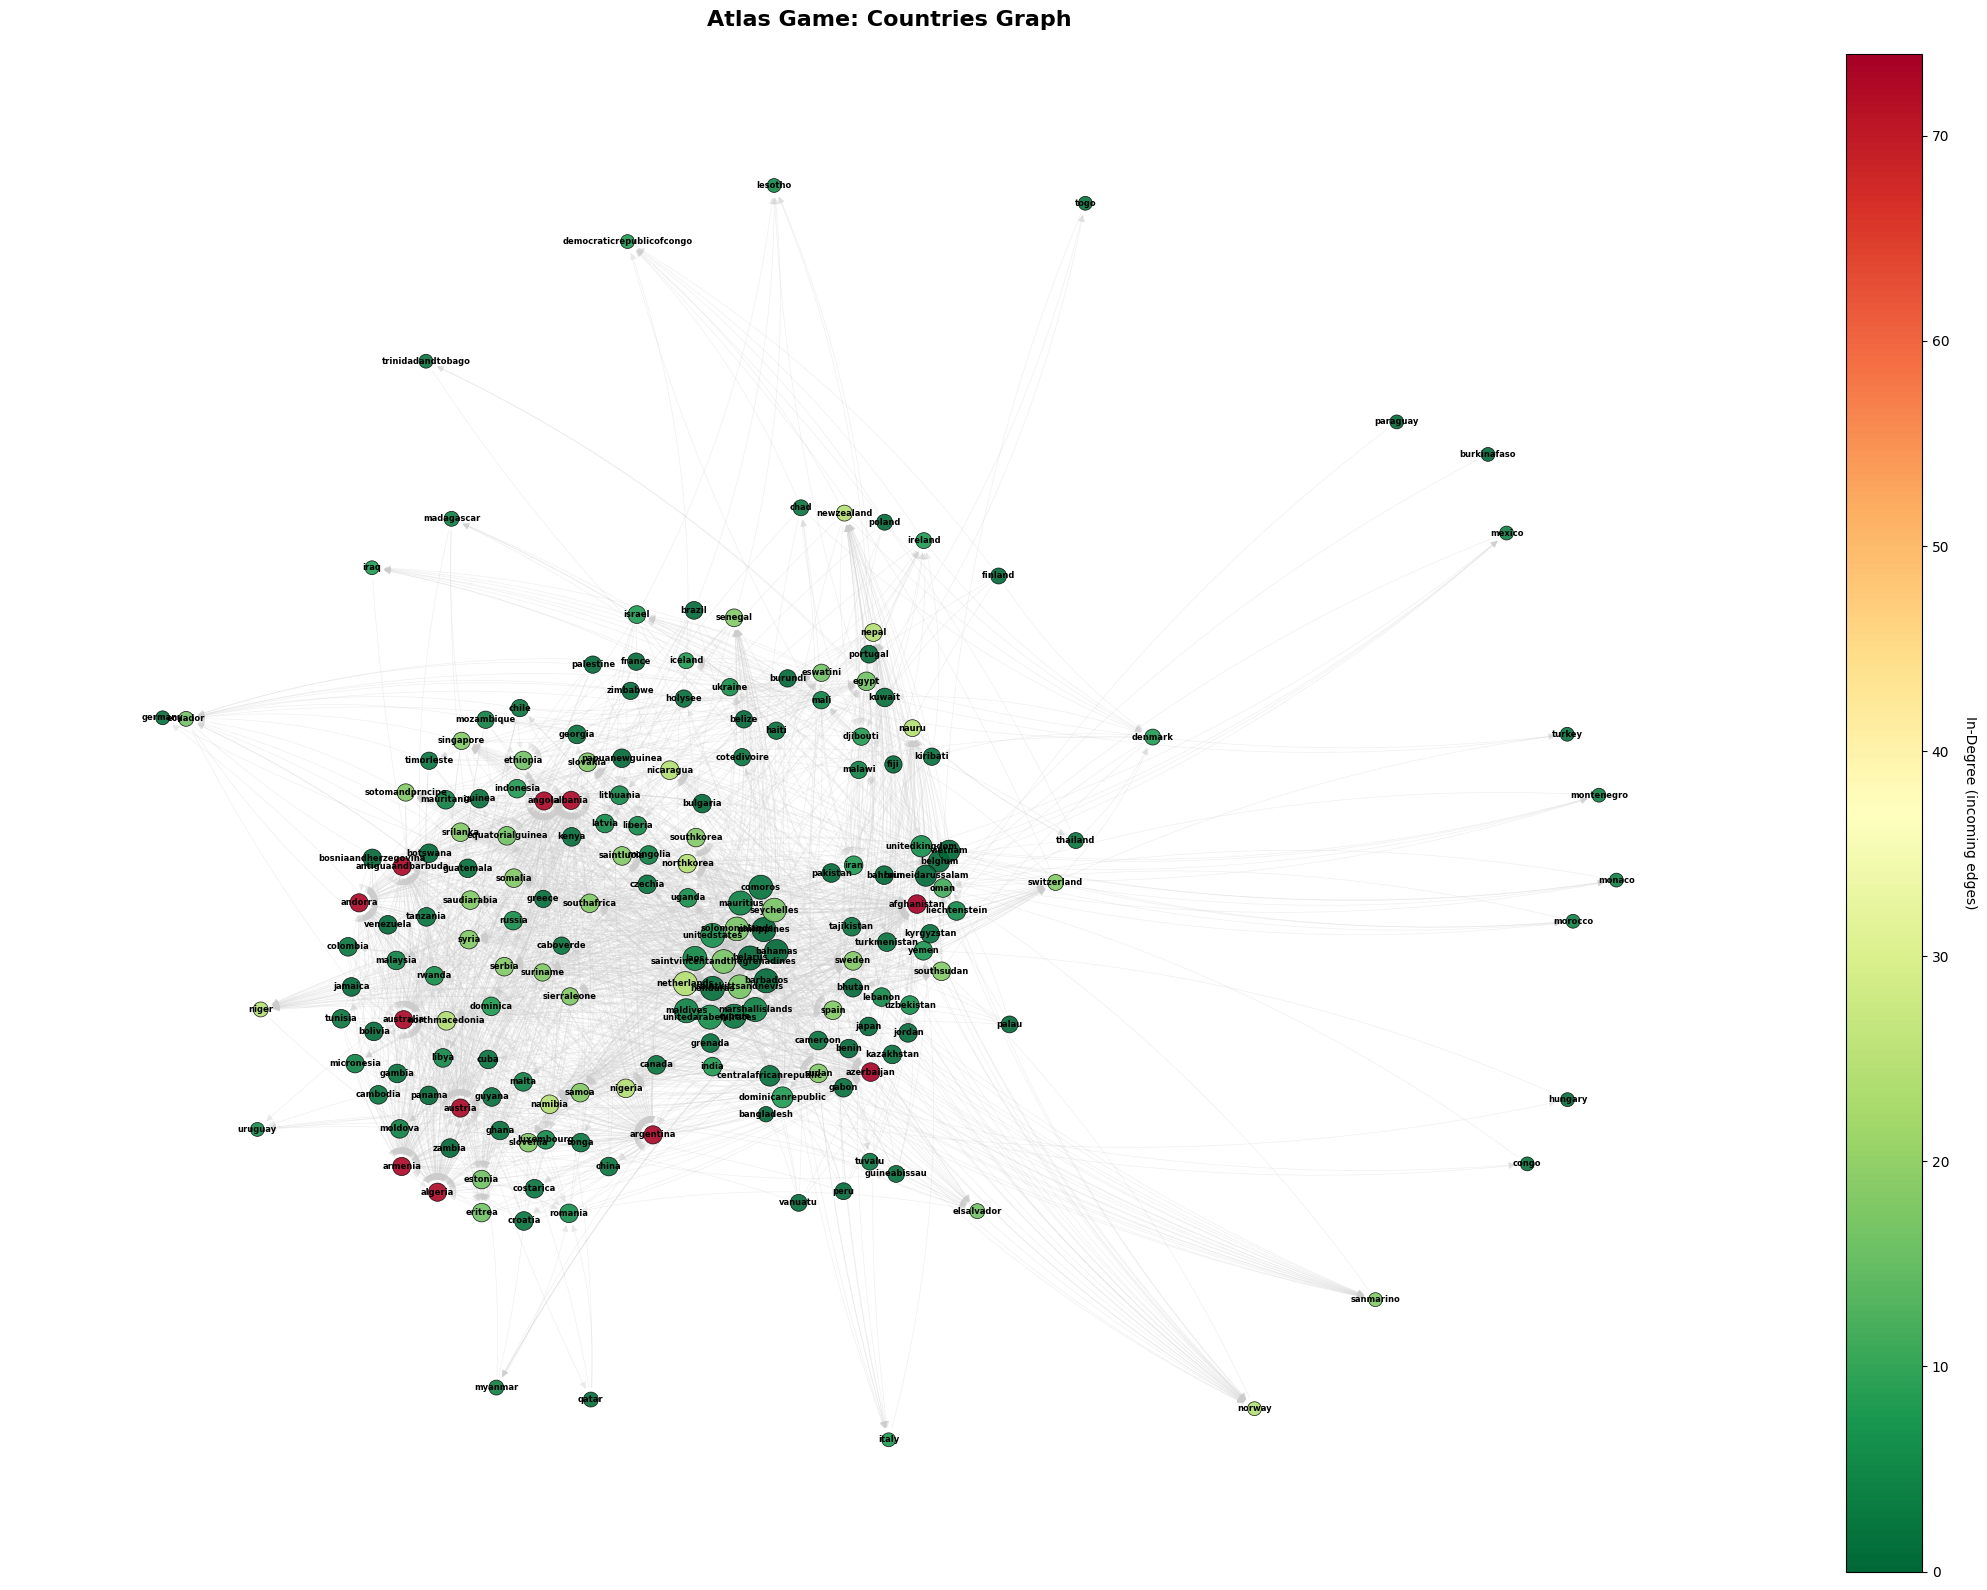

In [23]:
visualizer.visualize_countries_graph(G_country, title="Atlas Game: Countries Graph")

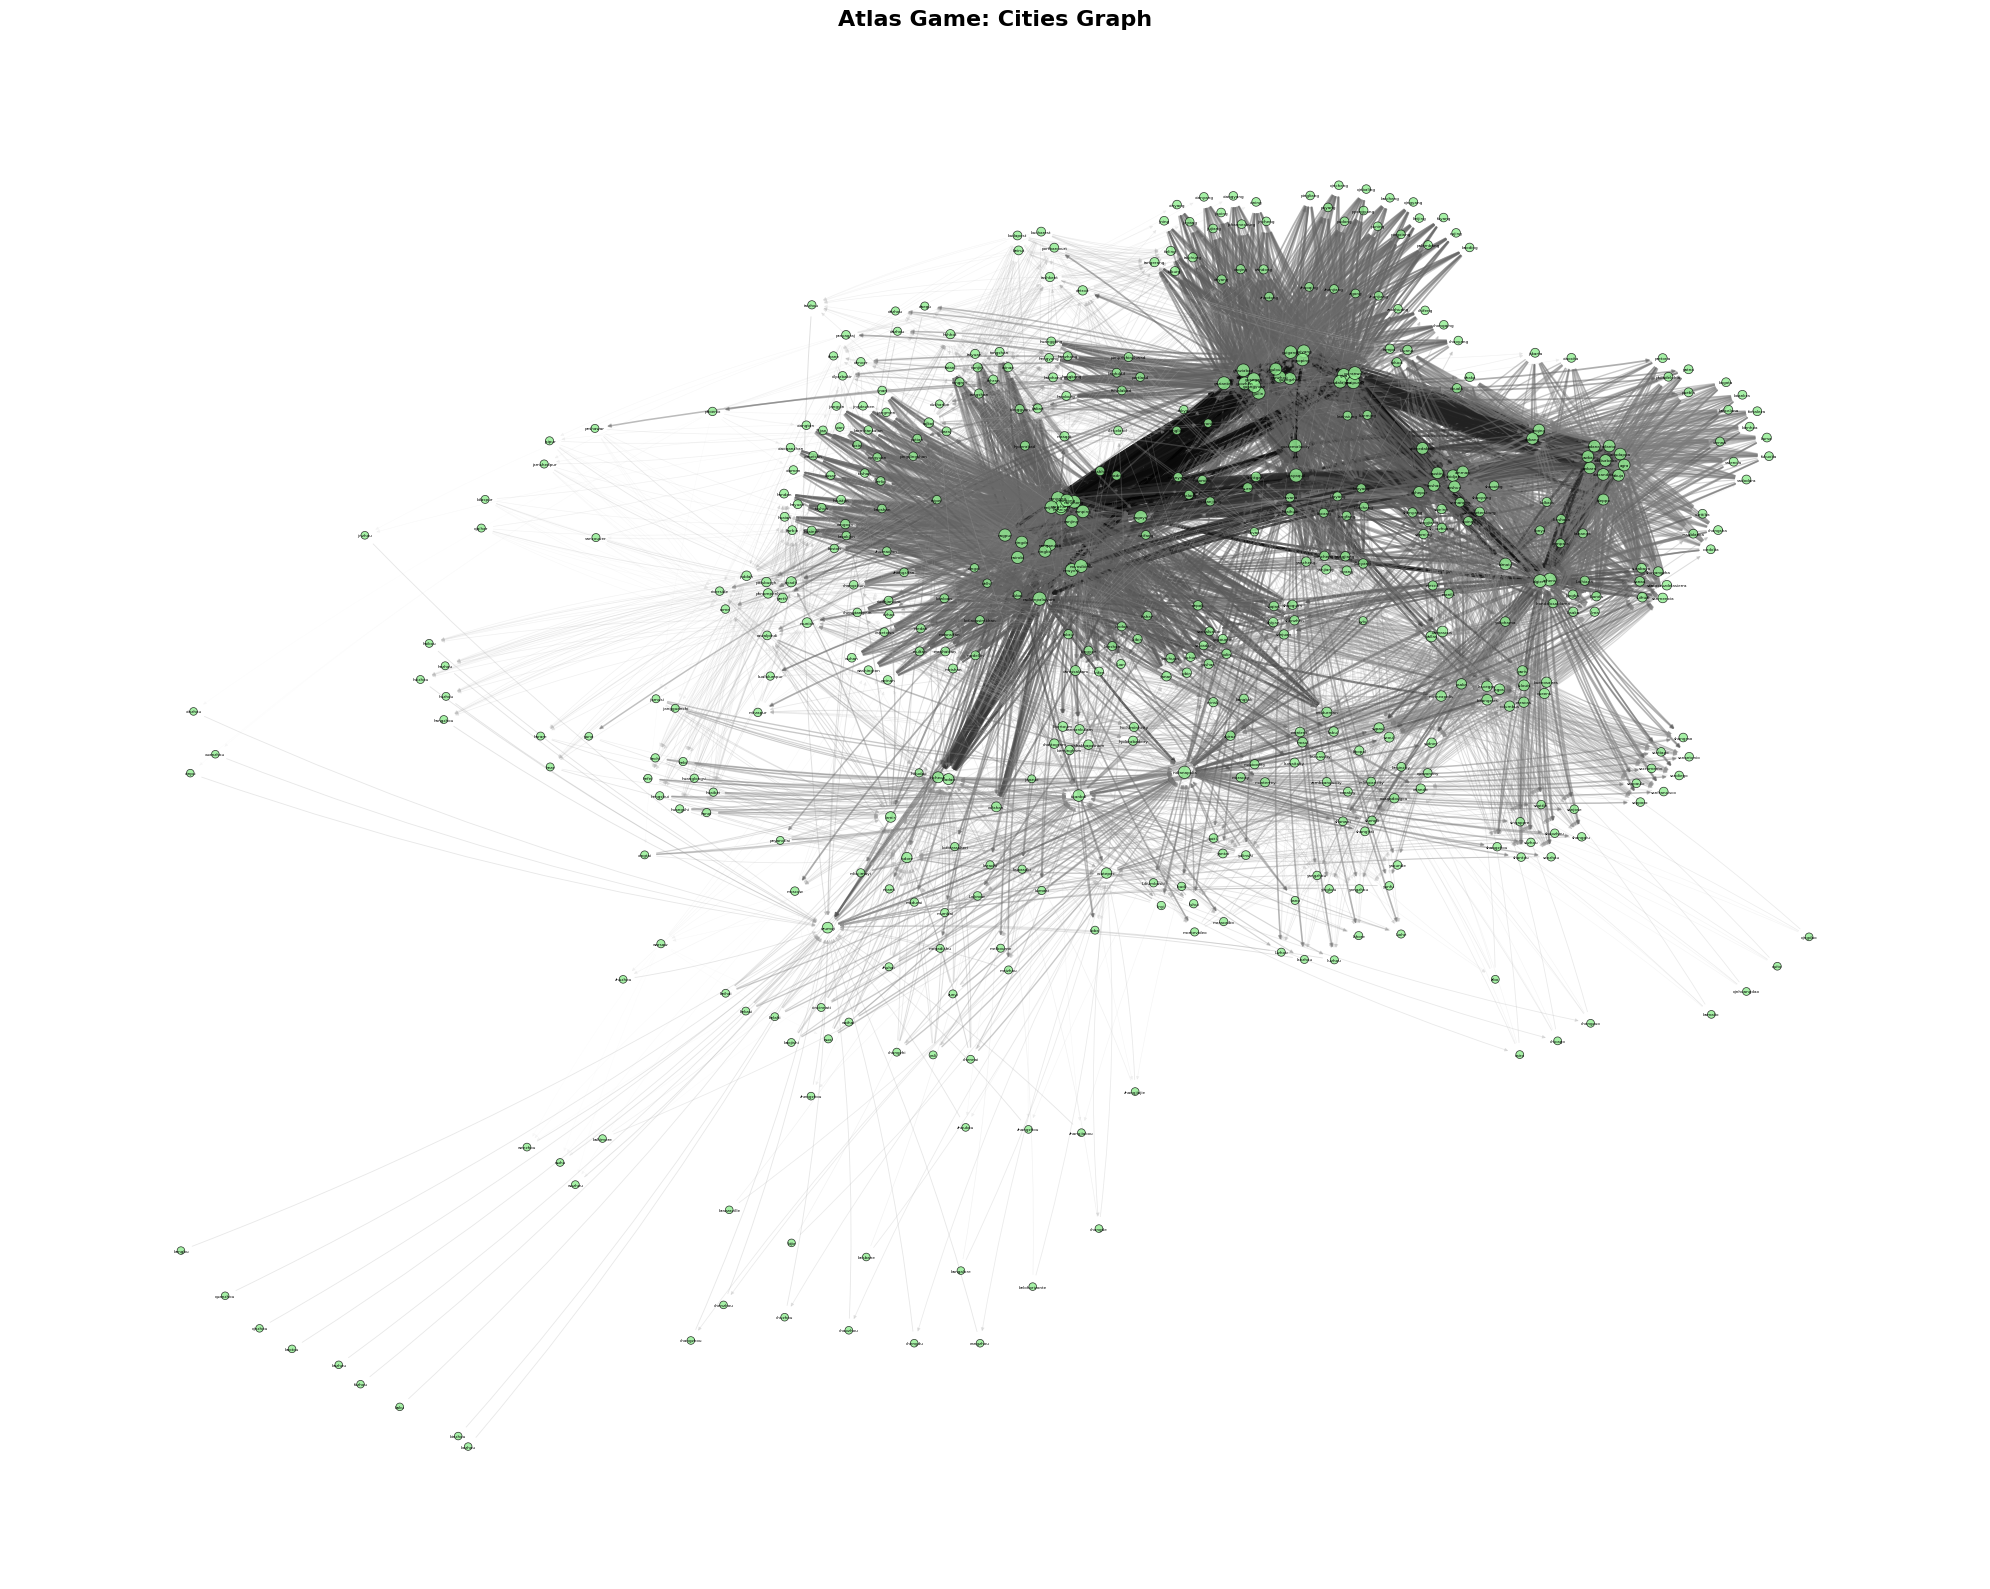

In [24]:
visualizer.visualize_cities_graph(G_city, title="Atlas Game: Cities Graph")

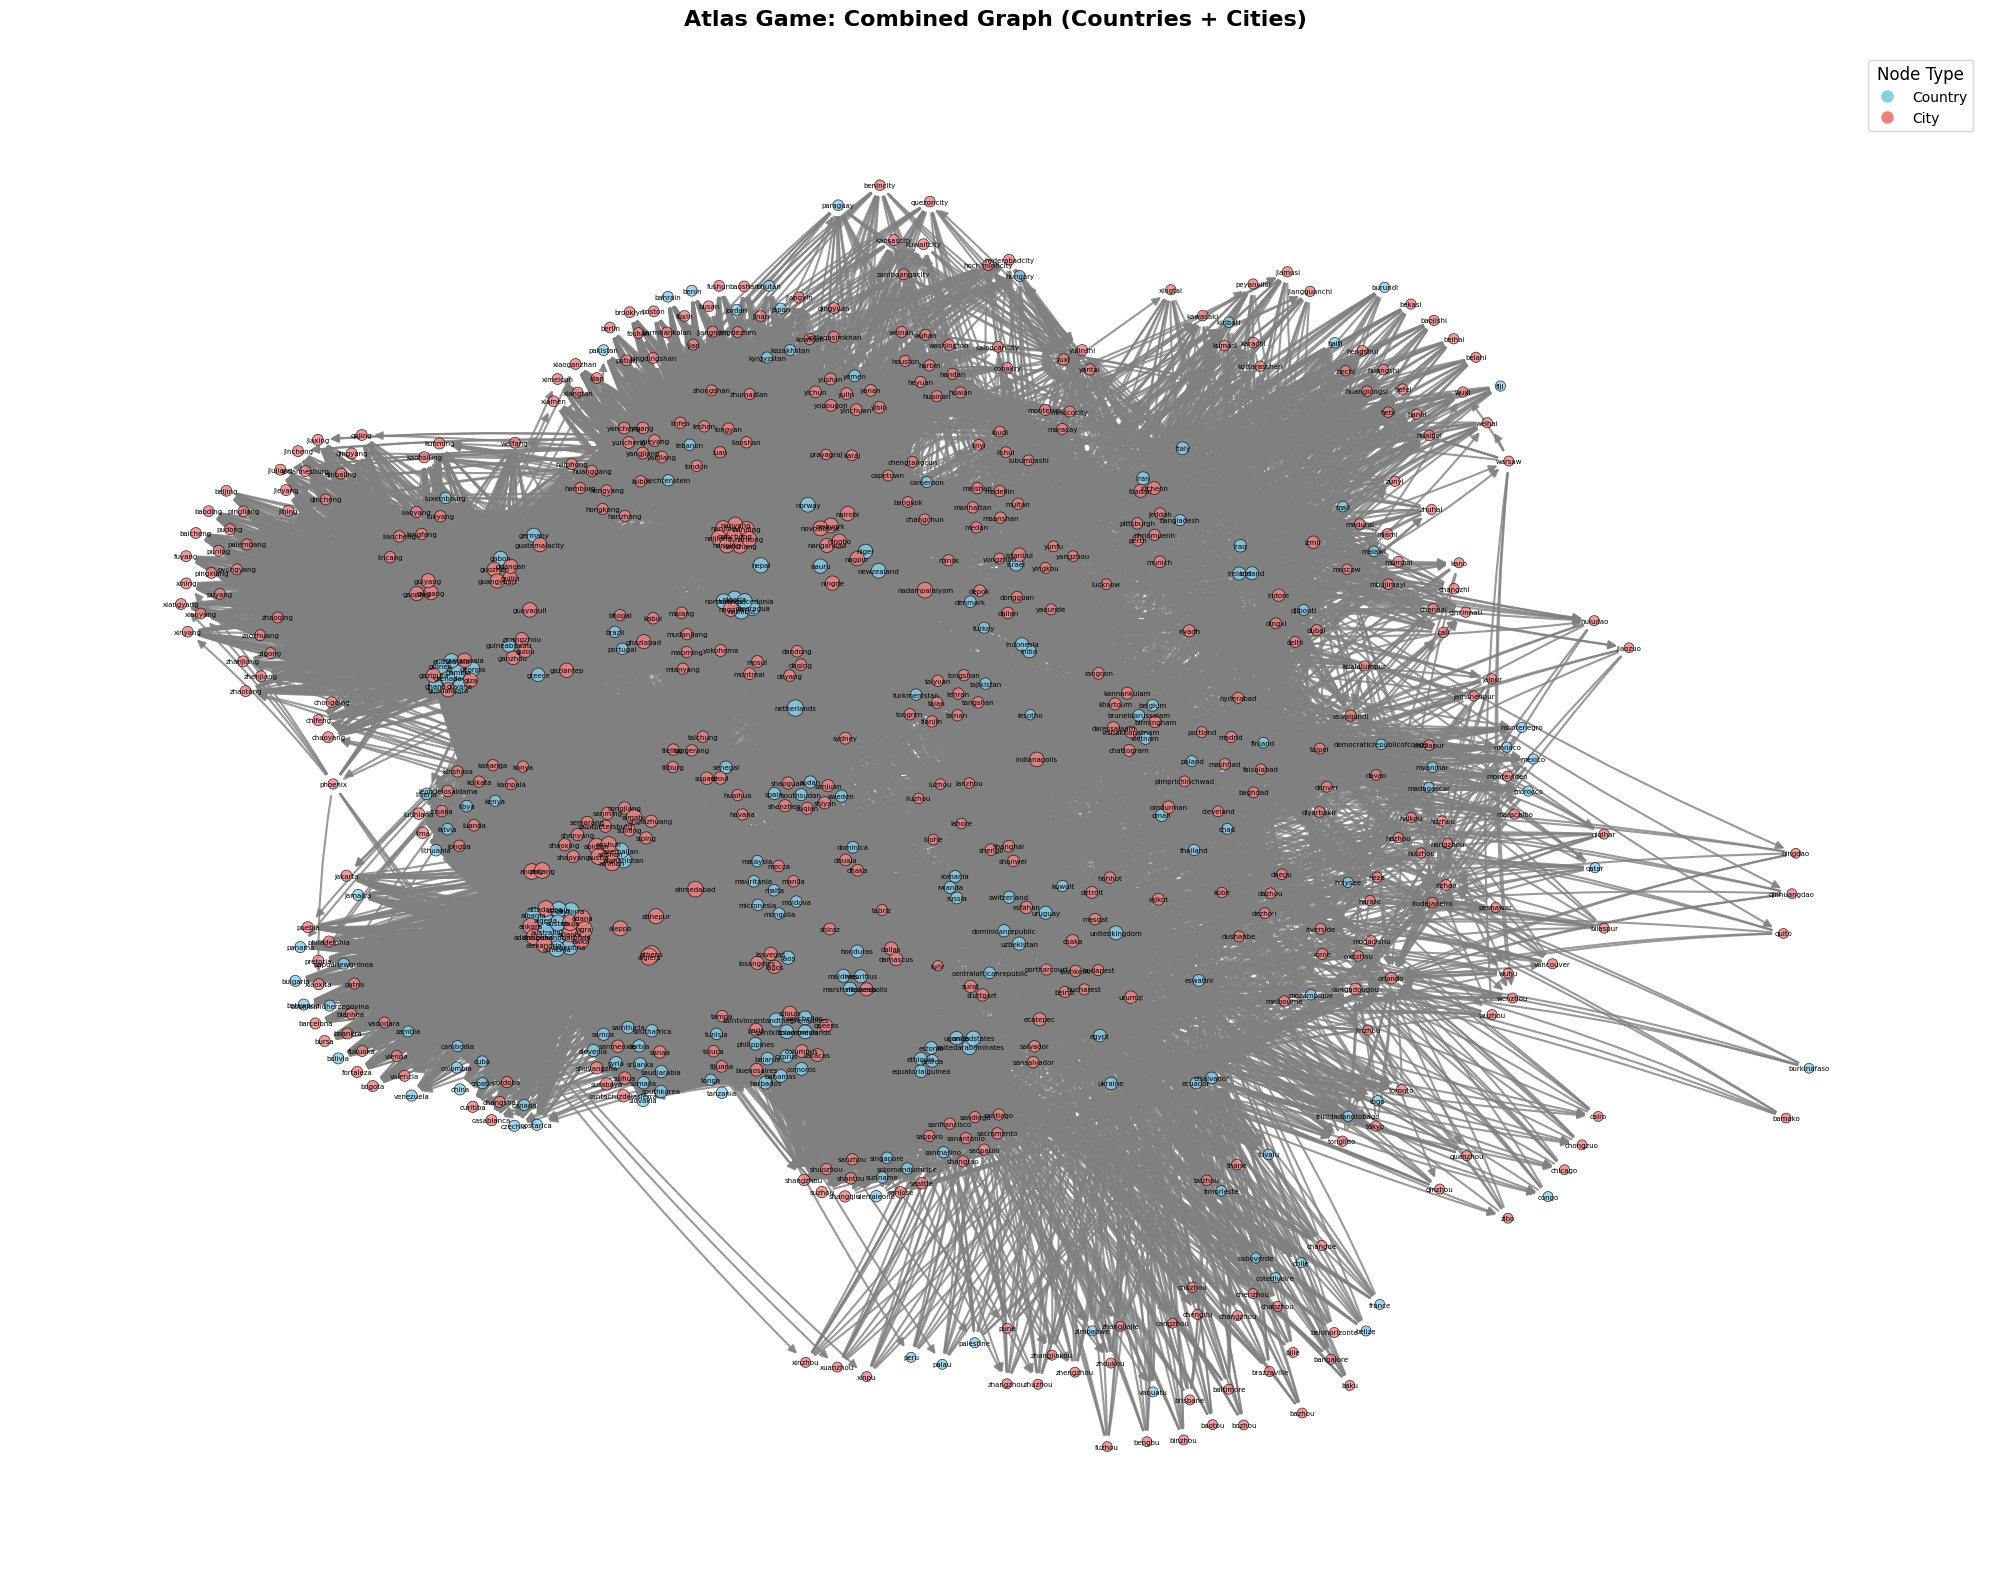

In [25]:
# run with spring layout, all light edges, and all labels, with color legend
visualizer.visualize_combined_bipartite(
    countries, cities, G_combined,
    title="Atlas Game: Combined Graph (Countries + Cities)",
    layout_type='spring',        # Specify spring layout
    edge_filter_percentile=0, # Show 100% of edges (less aggressive filtering)
    label_top_k=None             # Display all labels
)

TASK 1: GRAPH ANALYSIS (6PROPERTIES AND PLOTS)

In [26]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sns.set_style("whitegrid")


class GraphAnalyzer:
    """Advanced graph theory analysis for Atlas game"""

    def __init__(self):
        self.metrics_cache = {}

    def compute_out_degree_centrality(self, graph: nx.DiGraph) -> Dict[str, int]:
        """How many options do I have from this position?"""
        out_degree = dict(graph.out_degree())
        self.metrics_cache['out_degree'] = out_degree
        return out_degree

    def compute_betweenness_centrality(self, graph: nx.DiGraph) -> Dict[str, float]:
        """Is this a bridge/bottleneck?"""
        betweenness = nx.betweenness_centrality(graph)
        self.metrics_cache['betweenness'] = betweenness
        return betweenness

    def compute_pagerank(self, graph: nx.DiGraph, alpha: float = 0.85) -> Dict[str, float]:
        """How important is this node in the network?"""
        pagerank = nx.pagerank(graph, alpha=alpha)
        self.metrics_cache['pagerank'] = pagerank
        return pagerank

    def compute_in_degree_centrality(self, graph: nx.DiGraph) -> Dict[str, int]:
        """How many ways can I reach this node?"""
        in_degree = dict(graph.in_degree())
        self.metrics_cache['in_degree'] = in_degree
        return in_degree

    def compute_strongly_connected_components(self, graph: nx.DiGraph) -> List[Set[str]]:
        """Can you loop indefinitely?"""
        sccs = list(nx.strongly_connected_components(graph))
        sccs.sort(key=len, reverse=True)
        self.metrics_cache['sccs'] = sccs
        return sccs

    def compute_density_and_diameter(self, graph: nx.DiGraph) -> Dict[str, float]:
        """How connected is the overall network?"""
        G_undirected = graph.to_undirected()

        density = nx.density(graph)

        # Check if the graph has any connected components before calculating diameter/shortest path
        if nx.number_connected_components(G_undirected) > 0:
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            subgraph = G_undirected.subgraph(largest_cc)
            # Ensure the subgraph is not empty or single node with no edges for diameter
            if len(subgraph) > 1 and subgraph.number_of_edges() > 0:
                diameter = nx.diameter(subgraph)
                avg_shortest_path = nx.average_shortest_path_length(subgraph)
            else:
                diameter = 'N/A' # Cannot compute diameter for trivial component
                avg_shortest_path = 'N/A'
        else:
            diameter = 'N/A'
            avg_shortest_path = 'N/A'

        return {
            'density': density,
            'diameter': diameter,
            'avg_shortest_path': avg_shortest_path,
            'num_connected_components': nx.number_connected_components(G_undirected)
        }

    def compute_winning_positions(self, graph: nx.DiGraph) -> Tuple[Set[str], Set[str], Set[str]]:
        """Game-theoretic analysis: Winning vs Losing positions"""
        logger.info("Computing game-theoretic winning positions...")

        losing = set([n for n, d in graph.out_degree() if d == 0])
        winning = set()

        max_iterations = graph.number_of_nodes()
        for iteration in range(max_iterations):
            new_winning = set()

            for node in graph.nodes():
                if node not in losing and node not in winning:
                    successors = set(graph.successors(node))

                    if not successors:
                        losing.add(node)
                    elif all(s in winning for s in successors):
                        losing.add(node)
                    elif any(s in losing for s in successors):
                        new_winning.add(node)

            winning.update(new_winning)

            if not new_winning:
                break

        uncertain = set(graph.nodes()) - winning - losing

        logger.info(f"Winning: {len(winning)}, Losing: {len(losing)}, Uncertain: {len(uncertain)}")

        return winning, losing, uncertain

    def analyze_trap_nodes(self, graph: nx.DiGraph) -> Dict:
        """Identify and analyze trap positions"""
        traps = [n for n, d in graph.out_degree() if d == 0]

        analysis = {
            'num_traps': len(traps),
            'trap_percentage': len(traps) / graph.number_of_nodes() * 100 if graph.number_of_nodes() > 0 else 0,
            'trap_examples': traps[:10],
            'trap_list': traps
        }

        return analysis

    def analyze_bottlenecks(self, graph: nx.DiGraph, top_k: int = 10) -> Dict:
        """Identify bottleneck nodes"""
        betweenness = self.compute_betweenness_centrality(graph)

        top_bottlenecks = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_k]

        analysis = {
            'top_bottlenecks': top_bottlenecks,
            'bottleneck_names': [name for name, _ in top_bottlenecks],
            'bottleneck_scores': [score for _, score in top_bottlenecks]
        }

        return analysis

    def analyze_letter_patterns(self, graph: nx.DiGraph) -> Dict:
        """Analyze network by first letters"""
        letter_stats = {}

        for node in graph.nodes():
            first_letter = node[0].lower() # Use the first letter of the node name

            if first_letter not in letter_stats:
                letter_stats[first_letter] = {
                    'count': 0,
                    'traps': 0,
                    'examples': []
                }

            letter_stats[first_letter]['count'] += 1
            letter_stats[first_letter]['examples'].append(node)

            if graph.out_degree(node) == 0:
                letter_stats[first_letter]['traps'] += 1

        # Calculate safety for each letter
        for letter, stats in letter_stats.items():
            num_places = stats['count']
            num_traps = stats['traps']
            letter_stats[letter]['safety'] = 1.0 - (num_traps / num_places) if num_places > 0 else 0
            letter_stats[letter]['examples'] = letter_stats[letter]['examples'][:3] # Limit examples

        return letter_stats

    def plot_centrality_distributions(self,
                                     graph: nx.DiGraph,
                                     save_path: str = None):
        """Plot distributions of centrality metrics"""
        out_deg = self.compute_out_degree_centrality(graph)
        in_deg = self.compute_in_degree_centrality(graph)
        betweenness = self.compute_betweenness_centrality(graph)
        pagerank = self.compute_pagerank(graph)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Centrality Metrics Distributions', fontsize=16, fontweight='bold')

        axes[0, 0].hist(out_deg.values(), bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Out-Degree Centrality', fontweight='bold')
        axes[0, 0].set_xlabel('Out-Degree')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(np.mean(list(out_deg.values())), color='red', linestyle='--', label='Mean')
        axes[0, 0].legend()

        axes[0, 1].hist(in_deg.values(), bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('In-Degree Centrality', fontweight='bold')
        axes[0, 1].set_xlabel('In-Degree')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].axvline(np.mean(list(in_deg.values())), color='red', linestyle='--', label='Mean')
        axes[0, 1].legend()

        axes[1, 0].hist(betweenness.values(), bins=30, color='#F18F01', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Betweenness Centrality', fontweight='bold')
        axes[1, 0].set_xlabel('Betweenness Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(np.mean(list(betweenness.values())), color='red', linestyle='--', label='Mean')
        axes[1, 0].legend()

        axes[1, 1].hist(pagerank.values(), bins=30, color='#06A77D', alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('PageRank', fontweight='bold')
        axes[1, 1].set_xlabel('PageRank Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].axvline(np.mean(list(pagerank.values())), color='red', linestyle='--', label='Mean')
        axes[1, 1].legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved to {save_path}")

        plt.show()

    def plot_degree_scatter(
                           self,
                           graph: nx.DiGraph,
                           save_path: str = None):
        """Scatter plot: In-Degree vs Out-Degree"""
        in_deg = self.compute_in_degree_centrality(graph)
        out_deg = self.compute_out_degree_centrality(graph)

        fig, ax = plt.subplots(figsize=(12, 10))

        nodes = list(graph.nodes())
        in_vals = [in_deg[n] for n in nodes]
        out_vals = [out_deg[n] for n in nodes]

        betweenness = self.compute_betweenness_centrality(graph)
        colors = [betweenness[n] for n in nodes]

        scatter = ax.scatter(in_vals, out_vals, c=colors, s=100,
                           cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)

        traps = [n for n in nodes if out_deg[n] == 0]
        sources = [n for n in nodes if in_deg[n] == 0]

        for trap in traps[:5]:
            ax.annotate(trap, (in_deg[trap], out_deg[trap]),
                       fontsize=8, xytext=(5, 5), textcoords='offset points')

        for source in sources[:5]:
            ax.annotate(source, (in_deg[source], out_deg[source]),
                       fontsize=8, xytext=(5, 5), textcoords='offset points', color='red')

        ax.set_xlabel('In-Degree (incoming edges)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Out-Degree (outgoing edges)', fontsize=12, fontweight='bold')
        ax.set_title('Strategic Position Analysis: In vs Out Degree', fontsize=14, fontweight='bold')

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Betweenness Centrality', rotation=270, labelpad=20)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved to {save_path}")

        plt.show()

    def create_summary_table(
                            self,
                            graph: nx.DiGraph,
                            top_k: int = 20) -> pd.DataFrame:
        """Create comprehensive summary table"""
        nodes = list(graph.nodes())

        out_deg = self.compute_out_degree_centrality(graph)
        in_deg = self.compute_in_degree_centrality(graph)
        betweenness = self.compute_betweenness_centrality(graph)
        pagerank = self.compute_pagerank(graph)

        data = []
        for node in nodes:
            data.append({
                'Place': node,
                'Out-Degree': out_deg[node],
                'In-Degree': in_deg[node],
                'Betweenness': betweenness[node],
                'PageRank': pagerank[node],
                'Total-Degree': out_deg[node] + in_deg[node]
            })

        df = pd.DataFrame(data)
        df = df.sort_values('Betweenness', ascending=False)

        return df


    #  TIER 2 METHODS
    def compute_closeness_centrality(self, graph):
        closeness = nx.closeness_centrality(graph)
        self.metrics_cache['closeness'] = closeness
        return closeness

    def compute_clustering_coefficient(self, graph):
        clustering = nx.clustering(graph)
        self.metrics_cache['clustering'] = clustering
        return clustering

    def compute_eigenvector_centrality(self, graph, max_iter=1000):
        try:
            eigenvector = nx.eigenvector_centrality(graph, max_iter=max_iter)
        except:
            eigenvector = {n: 1/len(graph) for n in graph.nodes()}
        self.metrics_cache['eigenvector'] = eigenvector
        return eigenvector

    def compute_average_shortest_path(self, graph):
        G_undirected = graph.to_undirected()
        if nx.is_connected(G_undirected):
            avg_path = nx.average_shortest_path_length(G_undirected)
        else:
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            avg_path = nx.average_shortest_path_length(G_undirected.subgraph(largest_cc))
        return avg_path

    def compute_assortativity(self, graph):
        assortativity = nx.degree_assortativity_coefficient(graph)
        self.metrics_cache['assortativity'] = assortativity
        return assortativity

    #  Comprehensive report with all 11 metrics
    def print_extended_report(self, graph, name="Graph"):
        print(f"\n{'='*80}")
        print(f"EXTENDED GRAPH ANALYSIS: {name.upper()}")
        print(f"{'='*80}\n")

        # Tier 1 metrics
        out_deg = self.compute_out_degree_centrality(graph)
        in_deg = self.compute_in_degree_centrality(graph)
        betweenness = self.compute_betweenness_centrality(graph)
        pagerank = self.compute_pagerank(graph)
        sccs = self.compute_strongly_connected_components(graph)
        props = self.compute_density_and_diameter(graph)

        # Tier 2 metrics
        closeness = self.compute_closeness_centrality(graph)
        clustering = self.compute_clustering_coefficient(graph)
        eigenvector = self.compute_eigenvector_centrality(graph)
        avg_path = self.compute_average_shortest_path(graph)
        assortativity = self.compute_assortativity(graph)

        # Print summaries
        print("TIER 1: Node-Level Metrics")
        print(f"  Out-degree avg: {np.mean(list(out_deg.values())):.2f}")
        print(f"  In-degree avg: {np.mean(list(in_deg.values())):.2f}")
        print(f"  Betweenness avg: {np.mean(list(betweenness.values())):.4f}")
        print(f"  PageRank avg: {np.mean(list(pagerank.values())):.4f}")
        print(f"  SCC count: {len(sccs)}")

        print("\nTIER 2: Network-Level Metrics")
        print(f"  Closeness avg: {np.mean(list(closeness.values())):.4f}")
        print(f"  Clustering avg: {np.mean(list(clustering.values())):.4f}")
        print(f"  Eigenvector avg: {np.mean(list(eigenvector.values())):.4f}")
        print(f"  Avg shortest path: {avg_path:.2f}")
        print(f"  Assortativity: {assortativity:.4f}")

        print(f"\n{'='*80}\n")

    def plot_tier2_distributions(self, graph, save_path=None):
        """Plot distributions of Tier 2 metrics"""
        closeness = self.compute_closeness_centrality(graph)
        clustering = self.compute_clustering_coefficient(graph)
        eigenvector = self.compute_eigenvector_centrality(graph)

        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        fig.suptitle('Extended Metrics - Tier 2', fontsize=16, fontweight='bold')

        # Closeness
        axes[0, 0].hist(closeness.values(), bins=30, color='#FF6B6B', alpha=0.7)
        axes[0, 0].set_title('Closeness Centrality')
        axes[0, 0].set_xlabel('Closeness Score')

        # Clustering
        axes[0, 1].hist(clustering.values(), bins=30, color='#4ECDC4', alpha=0.7)
        axes[0, 1].set_title('Clustering Coefficient')
        axes[0, 1].set_xlabel('Clustering Score')

        # Eigenvector
        axes[1, 0].hist(eigenvector.values(), bins=30, color='#95E1D3', alpha=0.7)
        axes[1, 0].set_title('Eigenvector Centrality')
        axes[1, 0].set_xlabel('Eigenvector Score')

        # Combined scatter
        out_deg = self.compute_out_degree_centrality(graph)
        axes[1, 1].scatter(list(out_deg.values()), list(closeness.values()),
                          c=list(clustering.values()), cmap='viridis', alpha=0.6)
        axes[1, 1].set_title('Out-Degree vs Closeness')
        axes[1, 1].set_xlabel('Out-Degree')
        axes[1, 1].set_ylabel('Closeness')



        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


In [27]:
analyzer = GraphAnalyzer()
print("GraphAnalyzer instance created and assigned to 'analyzer' variable.")

GraphAnalyzer instance created and assigned to 'analyzer' variable.


In [28]:
analyzer.print_extended_report(G_country, name='Countries')


EXTENDED GRAPH ANALYSIS: COUNTRIES

TIER 1: Node-Level Metrics
  Out-degree avg: 10.44
  In-degree avg: 10.44
  Betweenness avg: 0.0086
  PageRank avg: 0.0051
  SCC count: 43

TIER 2: Network-Level Metrics
  Closeness avg: 0.2668
  Clustering avg: 0.1828
  Eigenvector avg: 0.0241
  Avg shortest path: 2.44
  Assortativity: -0.3062




In [29]:
analyzer.print_extended_report(G_city, name='Cities')


EXTENDED GRAPH ANALYSIS: CITIES

TIER 1: Node-Level Metrics
  Out-degree avg: 15.18
  In-degree avg: 15.18
  Betweenness avg: 0.0034
  PageRank avg: 0.0020
  SCC count: 63

TIER 2: Network-Level Metrics
  Closeness avg: 0.3049
  Clustering avg: 0.0686
  Eigenvector avg: 0.0234
  Avg shortest path: 2.48
  Assortativity: -0.5146




In [30]:
analyzer.print_extended_report(G_combined, name='Combined')


EXTENDED GRAPH ANALYSIS: COMBINED

TIER 1: Node-Level Metrics
  Out-degree avg: 25.99
  In-degree avg: 25.99
  Betweenness avg: 0.0022
  PageRank avg: 0.0014
  SCC count: 70

TIER 2: Network-Level Metrics
  Closeness avg: 0.3518
  Clustering avg: 0.0867
  Eigenvector avg: 0.0176
  Avg shortest path: 2.27
  Assortativity: -0.2945




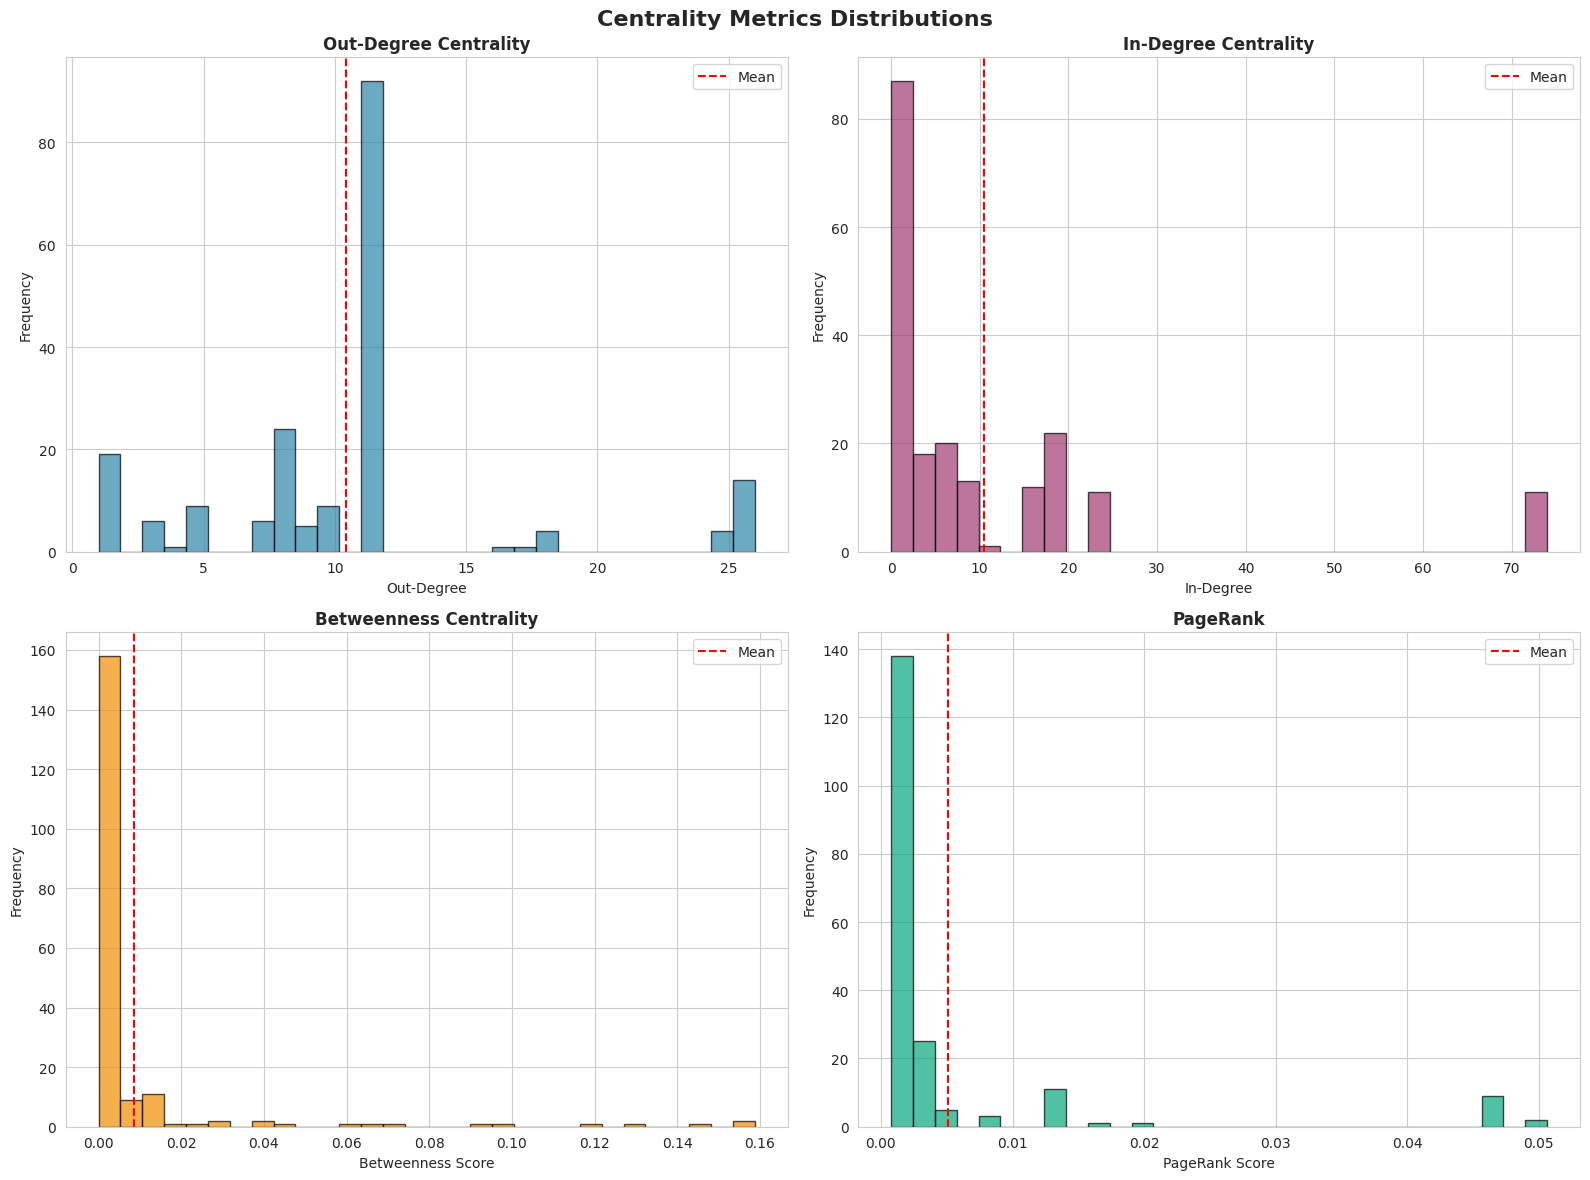

In [32]:
analyzer.plot_centrality_distributions(G_country)

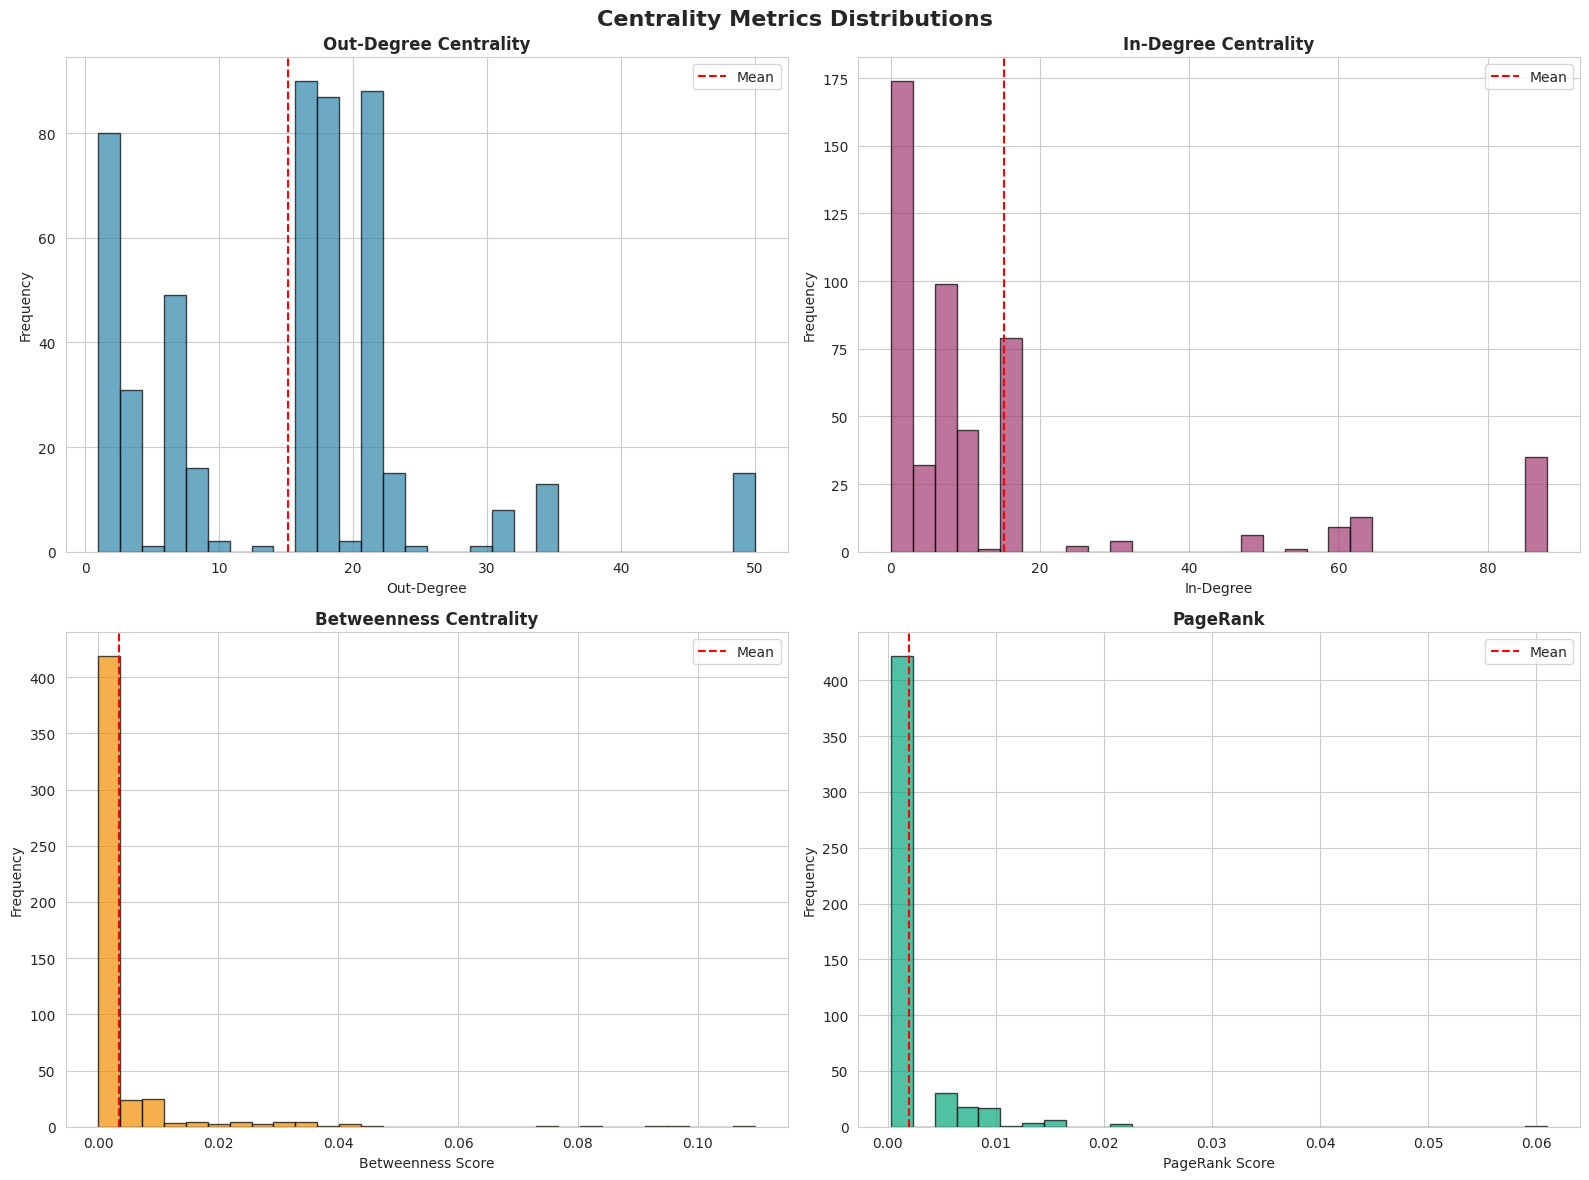

In [33]:
analyzer.plot_centrality_distributions(G_city)

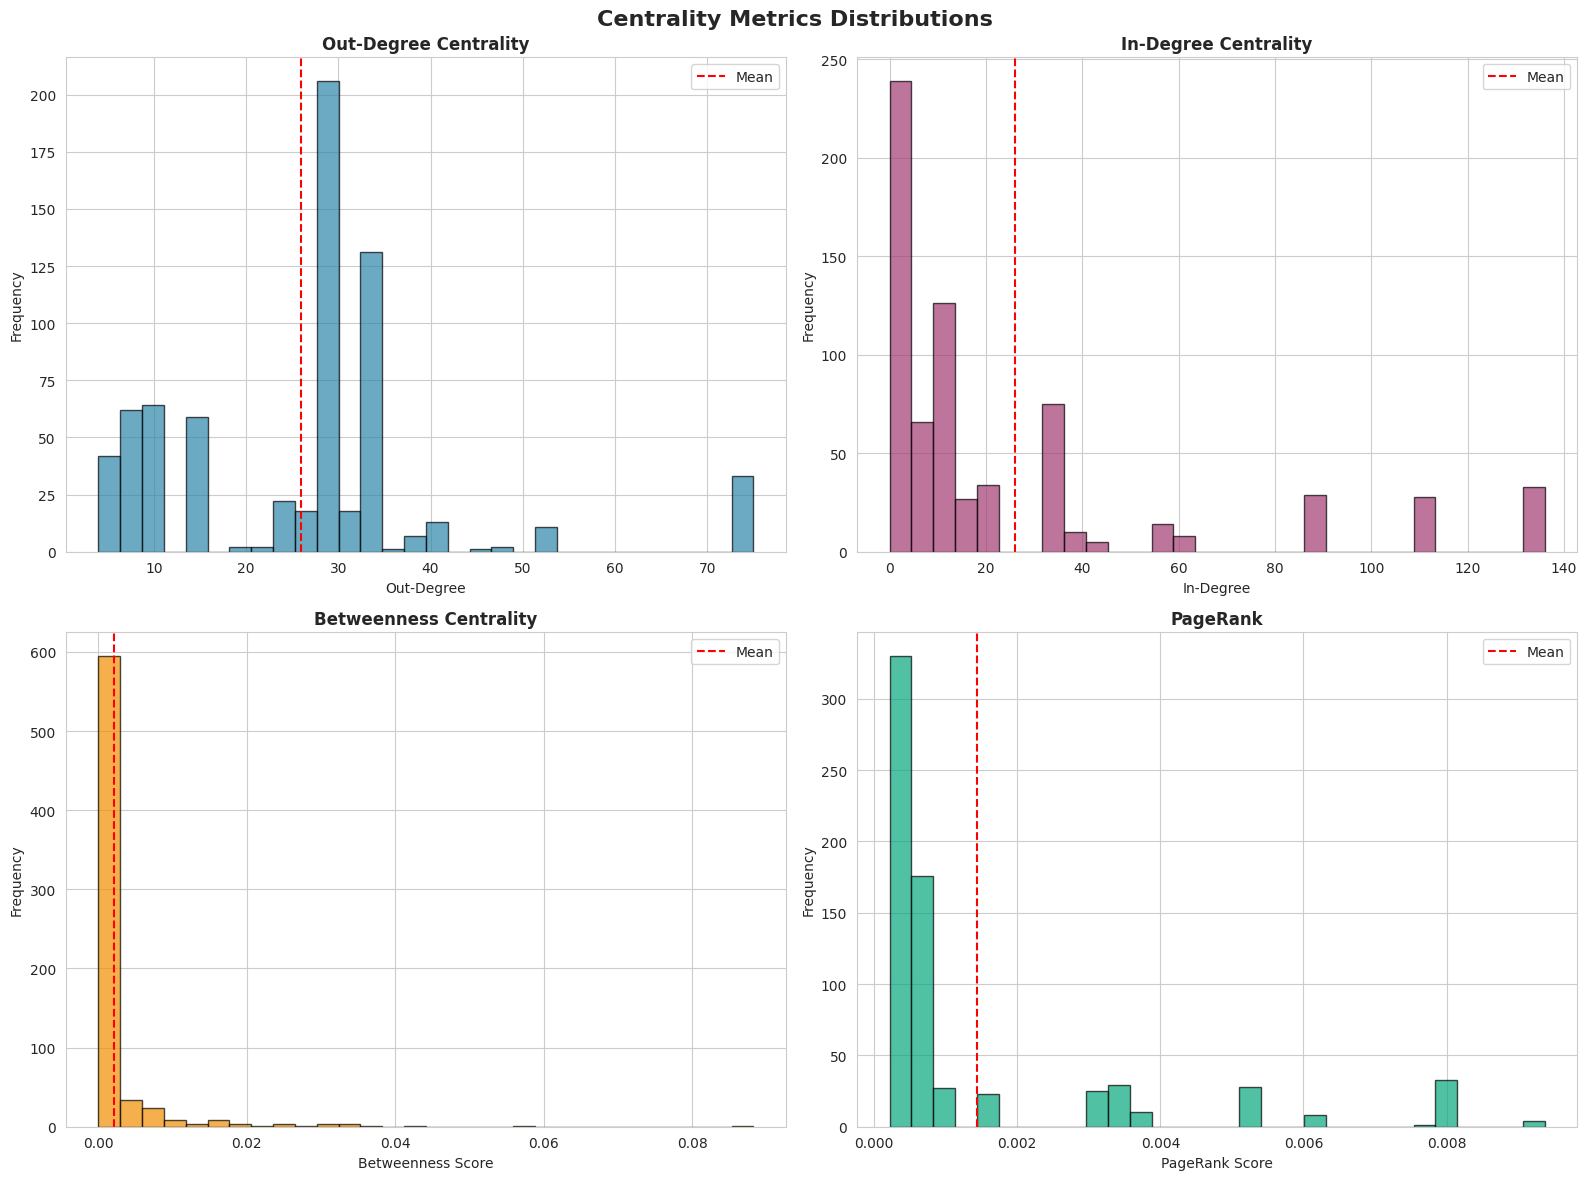

In [34]:
analyzer.plot_centrality_distributions(G_combined)

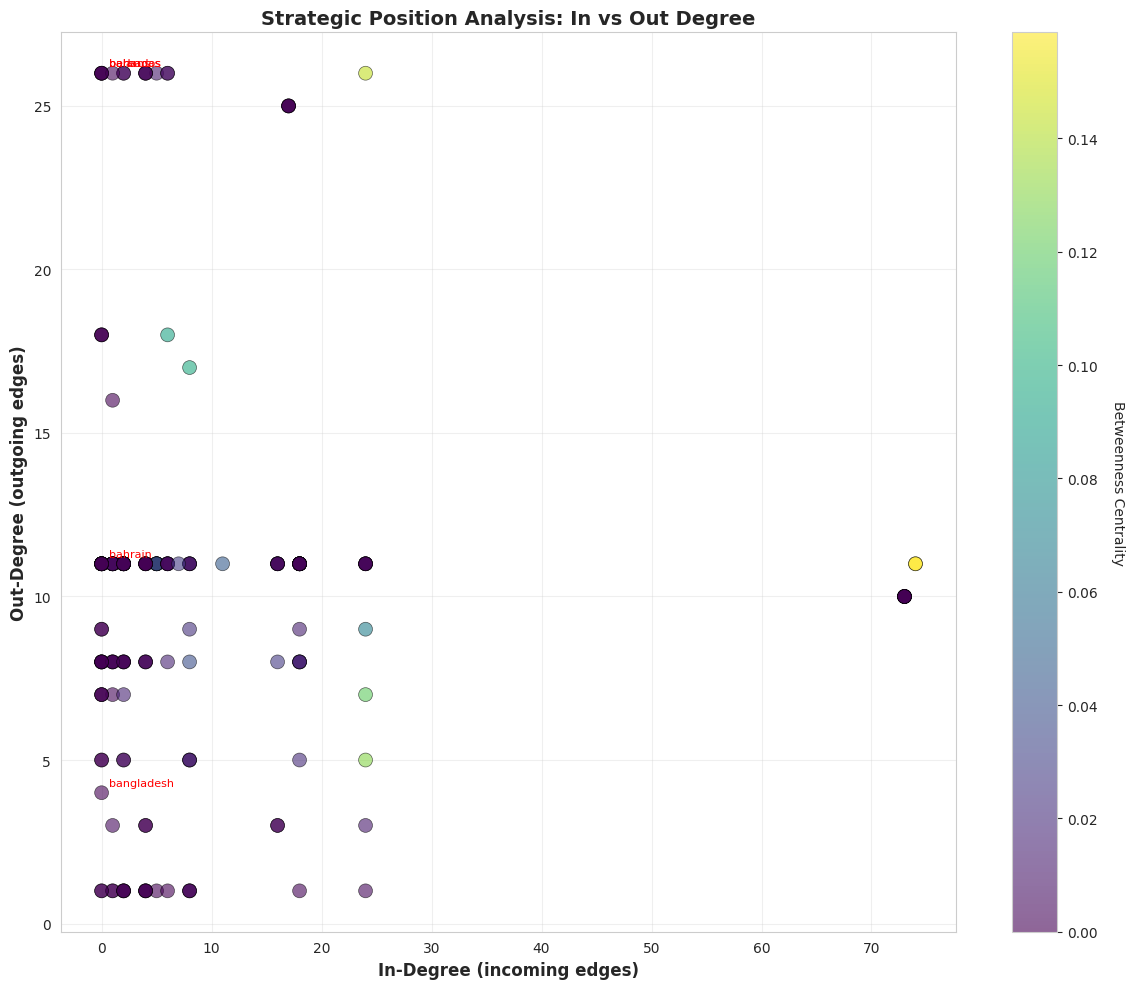

In [35]:
analyzer.plot_degree_scatter(G_country)

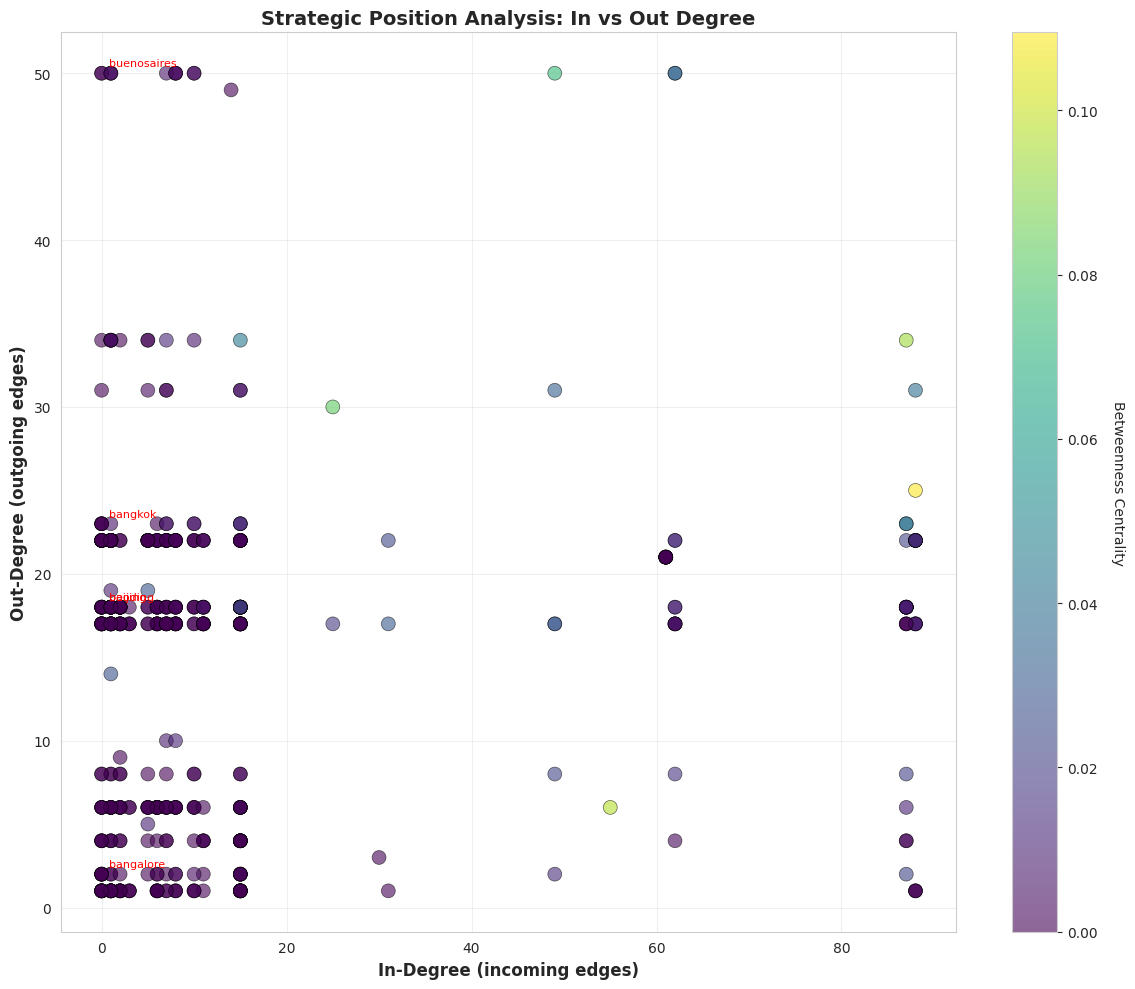

In [36]:
analyzer.plot_degree_scatter(G_city)

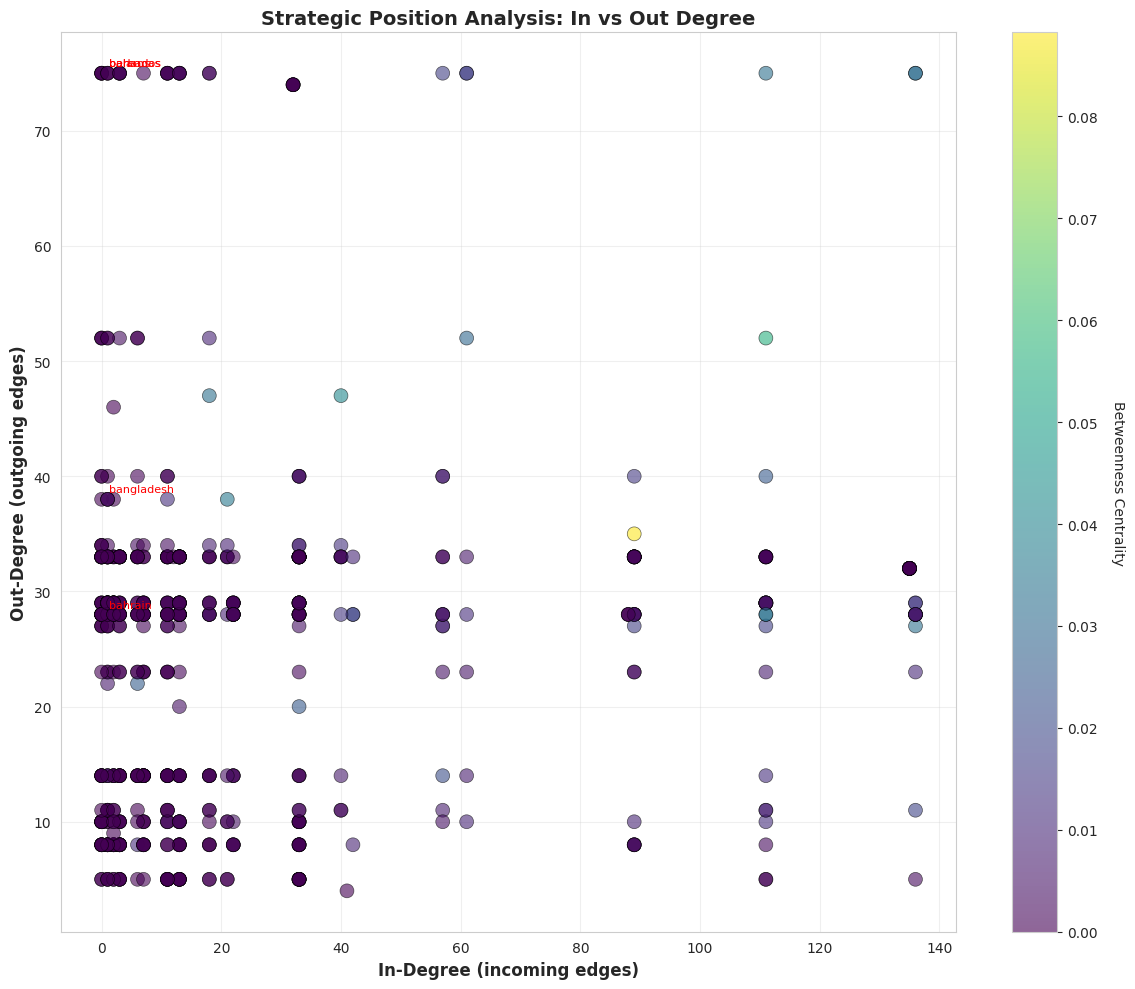

In [37]:
analyzer.plot_degree_scatter(G_combined)

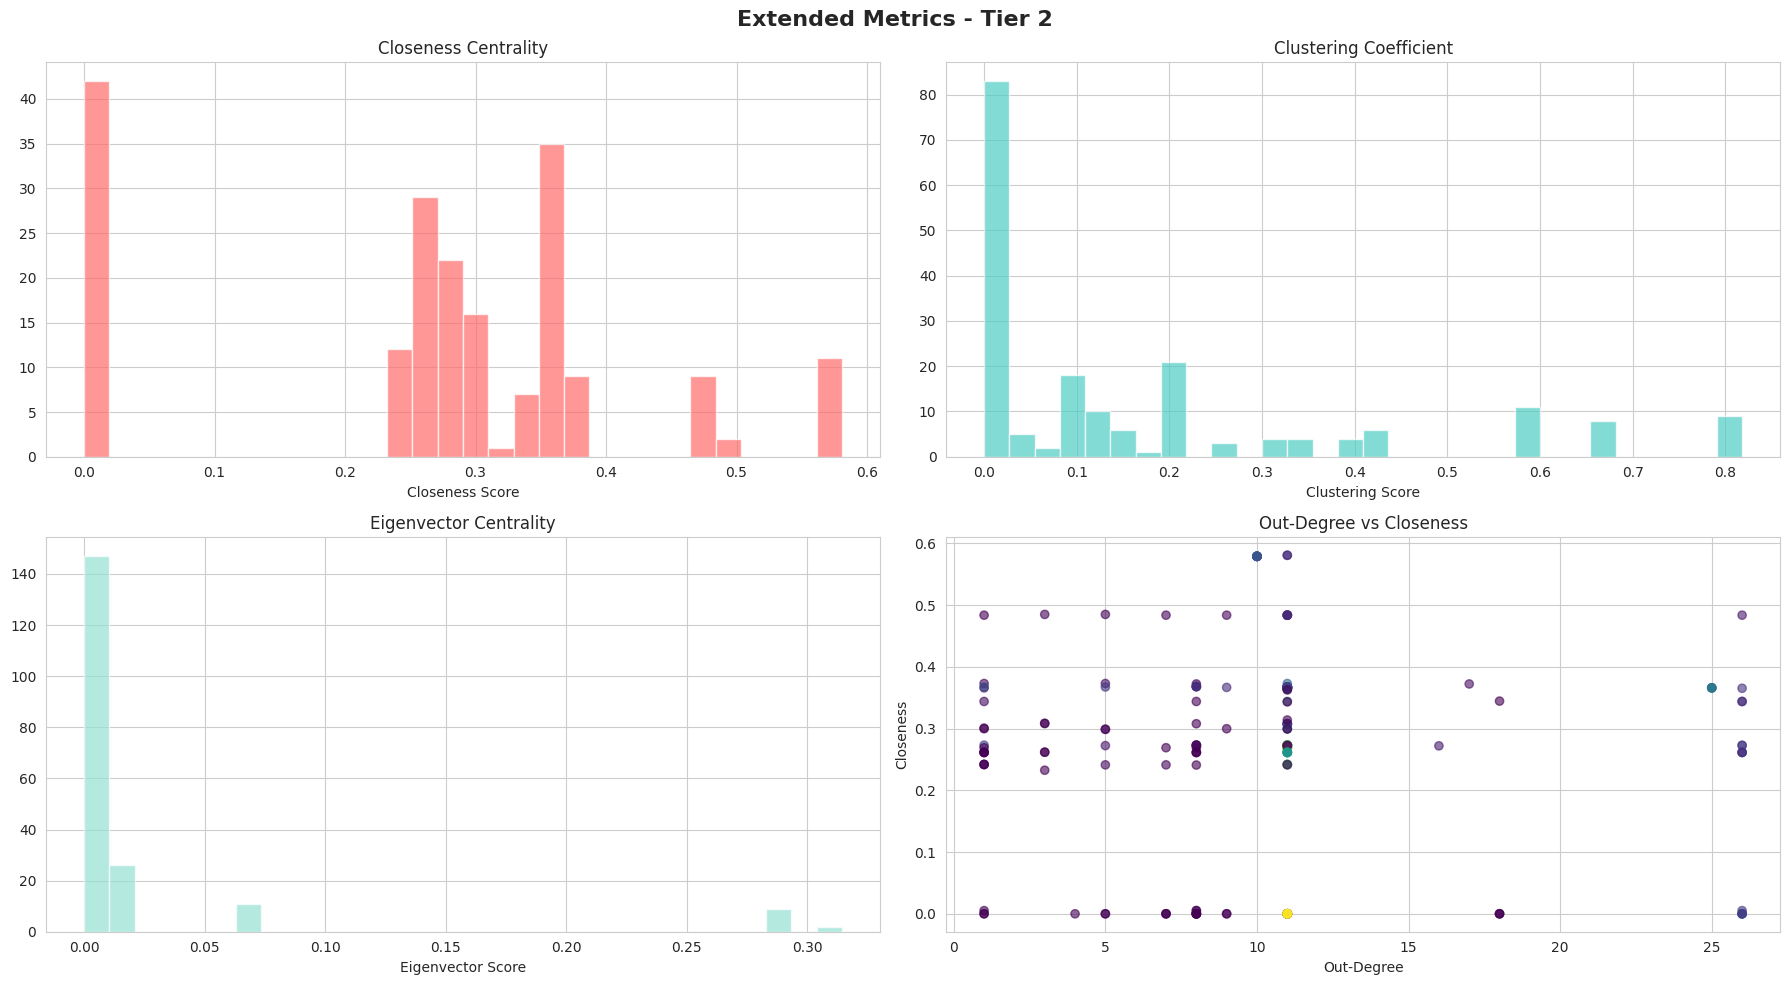

In [38]:
analyzer.plot_tier2_distributions(G_country)

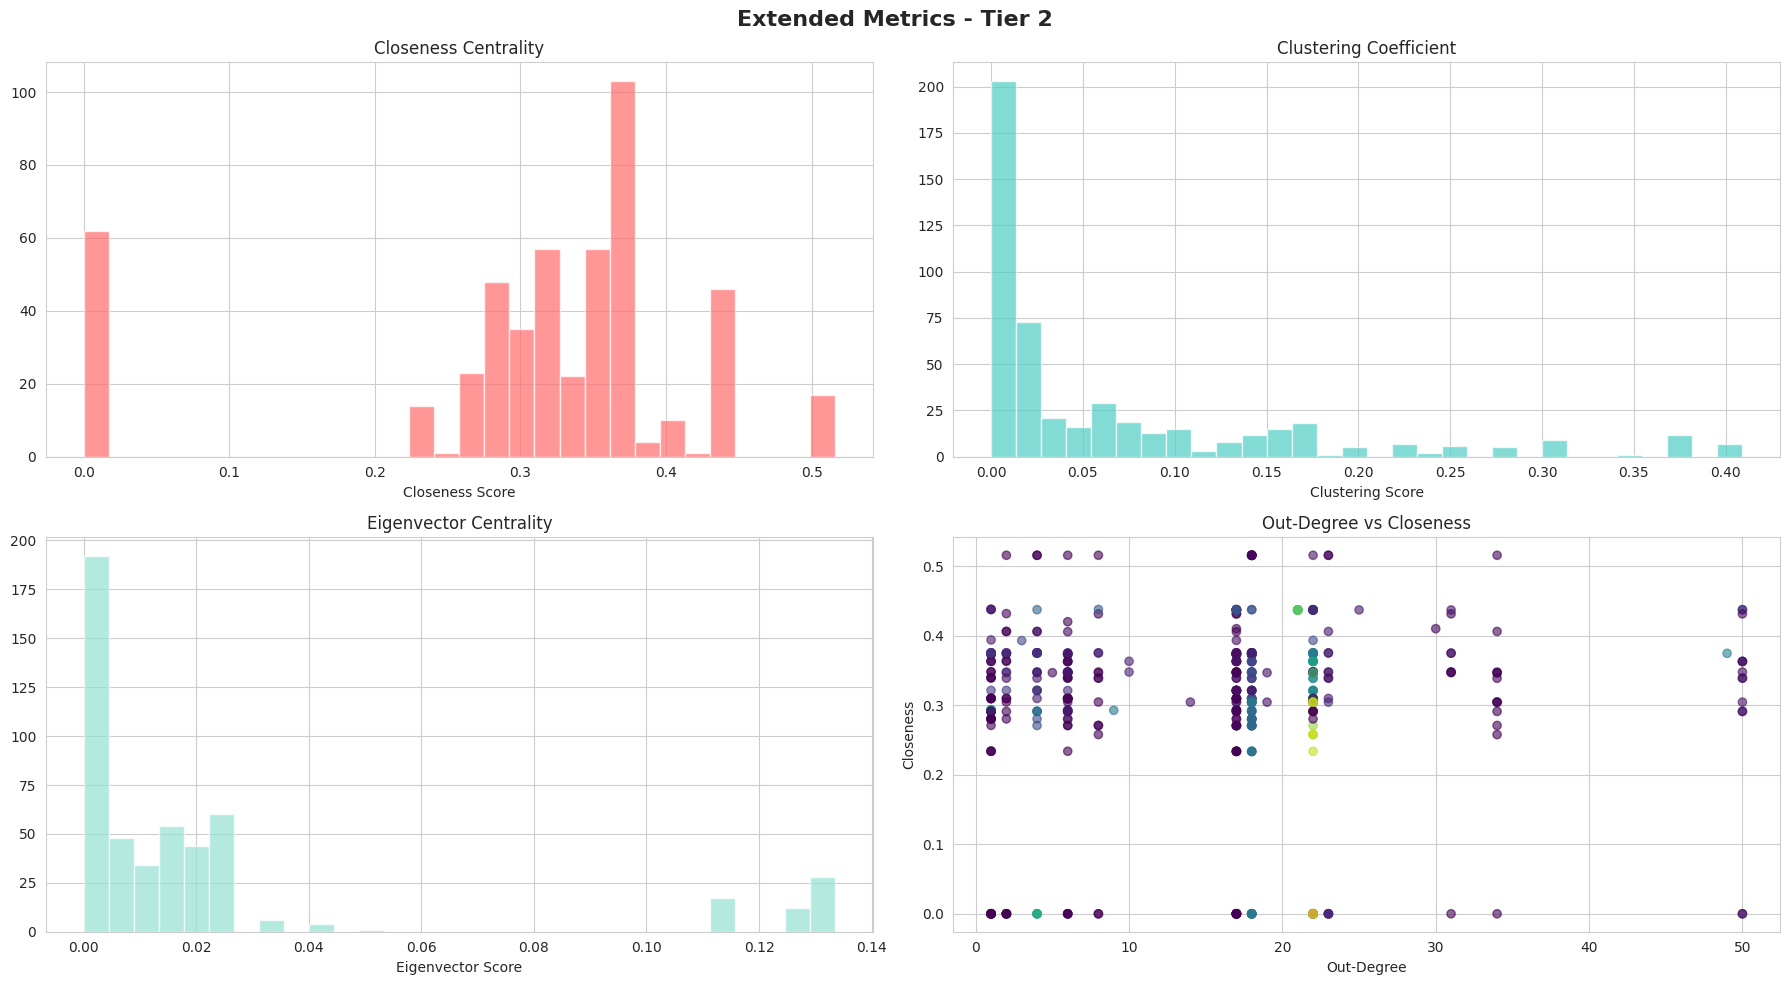

In [39]:
analyzer.plot_tier2_distributions(G_city)

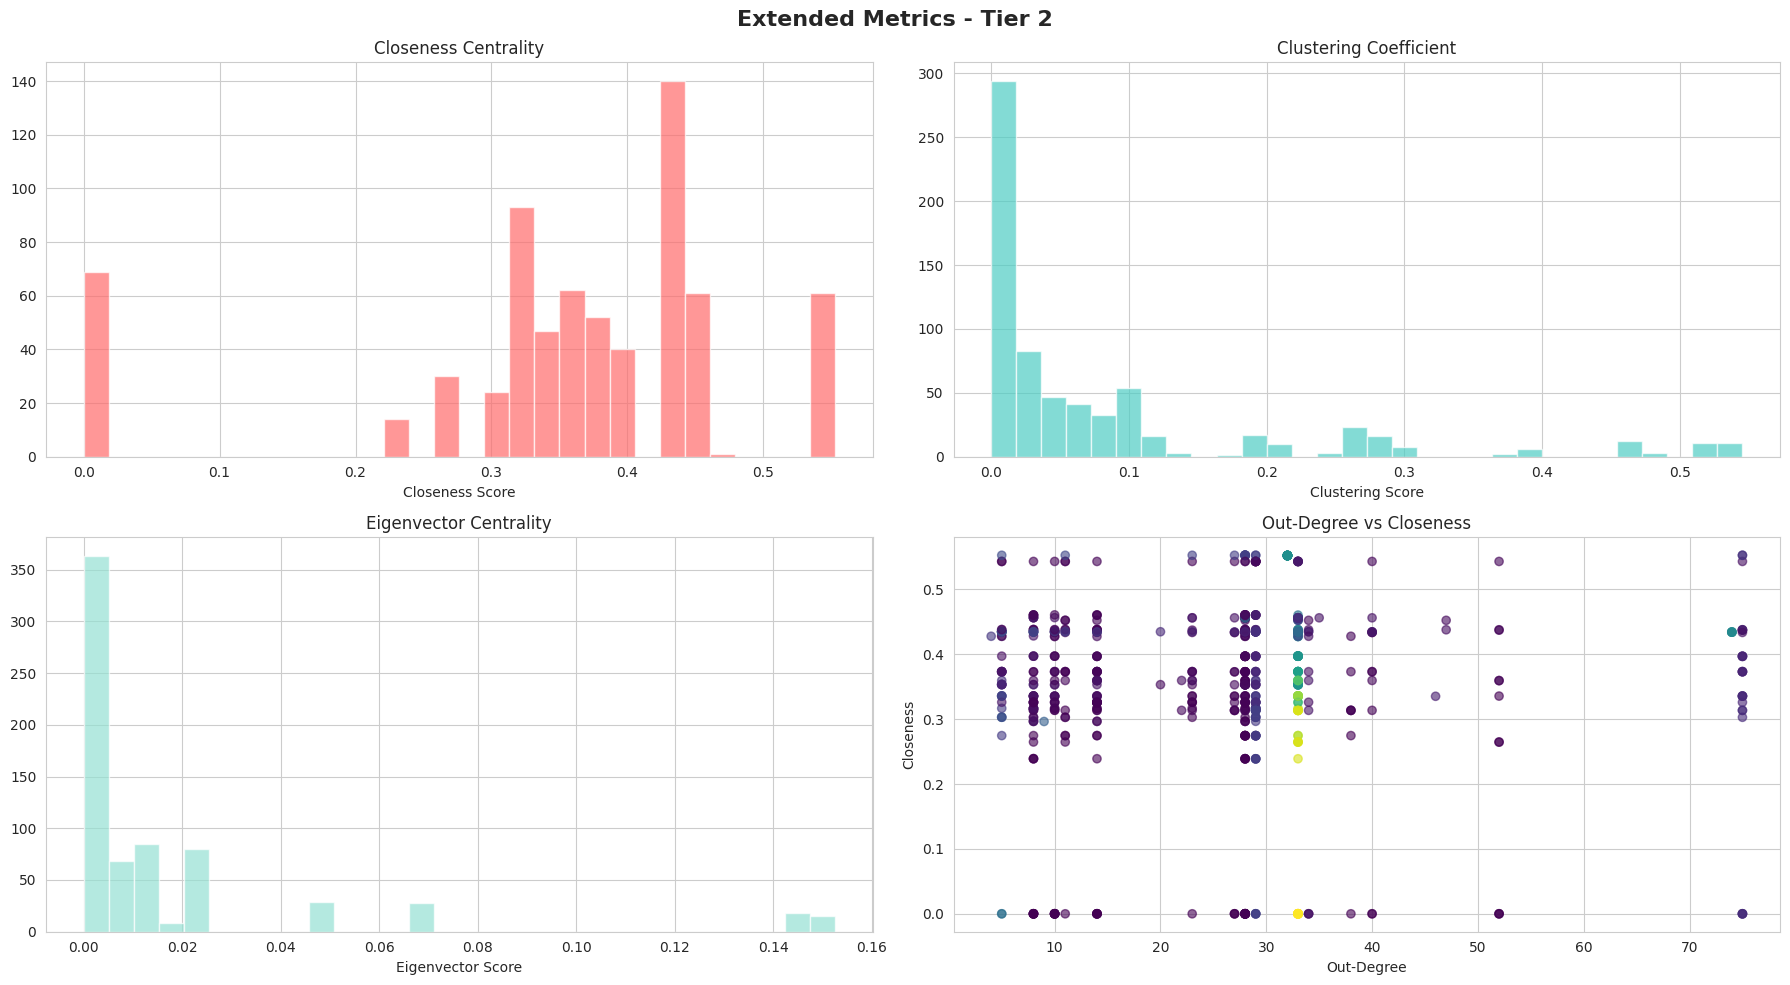

In [40]:
analyzer.plot_tier2_distributions(G_combined)

In [41]:
country_trap_nodes_analysis = analyzer.analyze_trap_nodes(G_country)
print("Trap Node Analysis for Countries:")
print(country_trap_nodes_analysis)

Trap Node Analysis for Countries:
{'num_traps': 0, 'trap_percentage': 0.0, 'trap_examples': [], 'trap_list': []}


In [42]:
city_trap_nodes_analysis = analyzer.analyze_trap_nodes(G_city)
print("Trap Node Analysis for Cities:")
print(city_trap_nodes_analysis)

Trap Node Analysis for Cities:
{'num_traps': 0, 'trap_percentage': 0.0, 'trap_examples': [], 'trap_list': []}


In [43]:
combined_trap_nodes_analysis = analyzer.analyze_trap_nodes(G_combined)
print("Trap Node Analysis for Combined Graph:")
print(combined_trap_nodes_analysis)

Trap Node Analysis for Combined Graph:
{'num_traps': 0, 'trap_percentage': 0.0, 'trap_examples': [], 'trap_list': []}


In [44]:
country_bottleneck_analysis = analyzer.analyze_bottlenecks(G_country)
print("Top Bottleneck Nodes for Countries:")
for node, score in country_bottleneck_analysis['top_bottlenecks']:
    print(f"- {node}: {score:.4f}")

Top Bottleneck Nodes for Countries:
- afghanistan: 0.1587
- azerbaijan: 0.1587
- netherlands: 0.1443
- newzealand: 0.1297
- nauru: 0.1202
- dominicanrepublic: 0.0964
- unitedkingdom: 0.0926
- nepal: 0.0693
- egypt: 0.0647
- luxembourg: 0.0586


In [45]:
city_bottleneck_analysis = analyzer.analyze_bottlenecks(G_city)
print("Top Bottleneck Nodes for Cities:")
for node, score in city_bottleneck_analysis['top_bottlenecks']:
    print(f"- {node}: {score:.4f}")

Top Bottleneck Nodes for Cities:
- gaziantep: 0.1095
- urumqi: 0.0975
- nadampalaiyam: 0.0935
- ecatepec: 0.0823
- indianapolis: 0.0736
- riyadh: 0.0442
- newyork: 0.0414
- novosibirsk: 0.0414
- guayaquil: 0.0396
- ghaziabad: 0.0363


In [46]:
combined_bottleneck_analysis = analyzer.analyze_bottlenecks(G_combined)
print("Top Bottleneck Nodes for Combined Graph:")
for node, score in combined_bottleneck_analysis['top_bottlenecks']:
    print(f"- {node}: {score:.4f}")

Top Bottleneck Nodes for Combined Graph:
- gaziantep: 0.0882
- nadampalaiyam: 0.0559
- ecatepec: 0.0414
- riyadh: 0.0358
- newyork: 0.0332
- novosibirsk: 0.0332
- dominicanrepublic: 0.0327
- netherlands: 0.0326
- ahmedabad: 0.0321
- athens: 0.0313


In [47]:
country_letter_patterns_analysis = analyzer.analyze_letter_patterns(G_country)
print("Letter Pattern Analysis for Countries:")
for letter, stats in sorted(country_letter_patterns_analysis.items()):
    print(f"\nLetter '{letter.upper()}':")
    print(f"  Count: {stats['count']}")
    print(f"  Traps: {stats['traps']}")
    print(f"  Safety (1-Traps/Count): {stats['safety']:.2f}")
    print(f"  Examples: {', '.join(stats['examples'])}")

Letter Pattern Analysis for Countries:

Letter 'A':
  Count: 11
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: afghanistan, albania, algeria

Letter 'B':
  Count: 17
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: bahamas, bahrain, bangladesh

Letter 'C':
  Count: 17
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: caboverde, cambodia, cameroon

Letter 'D':
  Count: 5
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: democraticrepublicofcongo, denmark, djibouti

Letter 'E':
  Count: 8
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: ecuador, egypt, elsalvador

Letter 'F':
  Count: 3
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: fiji, finland, france

Letter 'G':
  Count: 11
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: gabon, gambia, georgia

Letter 'H':
  Count: 4
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: haiti, holysee, honduras

Letter 'I':
  Count: 8
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: iceland, india, indonesi

In [48]:
city_letter_patterns_analysis = analyzer.analyze_letter_patterns(G_city)
print("Letter Pattern Analysis for Cities:")
for letter, stats in sorted(city_letter_patterns_analysis.items()):
    print(f"\nLetter '{letter.upper()}':")
    print(f"  Count: {stats['count']}")
    print(f"  Traps: {stats['traps']}")
    print(f"  Safety (1-Traps/Count): {stats['safety']:.2f}")
    print(f"  Examples: {', '.join(stats['examples'])}")

Letter Pattern Analysis for Cities:

Letter 'A':
  Count: 22
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: ahmedabad, ankara, addisababa

Letter 'B':
  Count: 41
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: beijing, bangkok, buenosaires

Letter 'C':
  Count: 30
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: cairo, chengdu, chennai

Letter 'D':
  Count: 22
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: delhi, dhaka, dongguan

Letter 'E':
  Count: 2
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: esfahan, ecatepec

Letter 'F':
  Count: 8
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: foshan, fuyang, fortaleza

Letter 'G':
  Count: 18
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: guangzhou, ganzhou, giza

Letter 'H':
  Count: 34
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: hochiminhcity, hyderabad, hangzhou

Letter 'I':
  Count: 6
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: istanbul, ibadan, izmir

Letter 'J':
  Count:

In [49]:
combined_letter_patterns_analysis = analyzer.analyze_letter_patterns(G_combined)
print("Letter Pattern Analysis for Combined Graph:")
for letter, stats in sorted(combined_letter_patterns_analysis.items()):
    print(f"\nLetter '{letter.upper()}':")
    print(f"  Count: {stats['count']}")
    print(f"  Traps: {stats['traps']}")
    print(f"  Safety (1-Traps/Count): {stats['safety']:.2f}")
    print(f"  Examples: {', '.join(stats['examples'])}")

Letter Pattern Analysis for Combined Graph:

Letter 'A':
  Count: 33
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: afghanistan, albania, algeria

Letter 'B':
  Count: 58
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: bahamas, bahrain, bangladesh

Letter 'C':
  Count: 47
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: caboverde, cambodia, cameroon

Letter 'D':
  Count: 27
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: democraticrepublicofcongo, denmark, djibouti

Letter 'E':
  Count: 10
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: ecuador, egypt, elsalvador

Letter 'F':
  Count: 11
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: fiji, finland, france

Letter 'G':
  Count: 29
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: gabon, gambia, georgia

Letter 'H':
  Count: 38
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: haiti, holysee, honduras

Letter 'I':
  Count: 14
  Traps: 0
  Safety (1-Traps/Count): 1.00
  Examples: iceland, india

In [50]:
winning_countries, losing_countries, uncertain_countries = analyzer.compute_winning_positions(G_country)

print(f"Winning Countries: {len(winning_countries)}")
print(f"Losing Countries: {len(losing_countries)}")
print(f"Uncertain Countries: {len(uncertain_countries)}")

Winning Countries: 0
Losing Countries: 0
Uncertain Countries: 195


In [51]:
winning_cities, losing_cities, uncertain_cities = analyzer.compute_winning_positions(G_city)

print(f"Winning Cities: {len(winning_cities)}")
print(f"Losing Cities: {len(losing_cities)}")
print(f"Uncertain Cities: {len(uncertain_cities)}")

Winning Cities: 0
Losing Cities: 0
Uncertain Cities: 500


In [52]:
winning_combined, losing_combined, uncertain_combined = analyzer.compute_winning_positions(G_combined)

print(f"Winning Combined: {len(winning_combined)}")
print(f"Losing Combined: {len(losing_combined)}")
print(f"Uncertain Combined: {len(uncertain_combined)}")

Winning Combined: 0
Losing Combined: 0
Uncertain Combined: 694


In [53]:
country_summary_df = analyzer.create_summary_table(G_country)
print("Top 20 Nodes by Betweenness Centrality for Countries:")
print(country_summary_df.head(20))

Top 20 Nodes by Betweenness Centrality for Countries:
                 Place  Out-Degree  In-Degree  Betweenness  PageRank  \
0          afghanistan          11         74     0.158736  0.050629   
10          azerbaijan          11         74     0.158736  0.050629   
122        netherlands          26         24     0.144284  0.013762   
123         newzealand           5         24     0.129738  0.013762   
120              nauru           7         24     0.120166  0.013762   
49   dominicanrepublic          17          8     0.096391  0.004865   
185      unitedkingdom          18          6     0.092612  0.002976   
121              nepal           9         24     0.069319  0.013762   
51               egypt          11         16     0.064665  0.003064   
100         luxembourg          11          5     0.058618  0.002624   
130               oman          11         11     0.045684  0.015845   
46             denmark           5          8     0.039193  0.004865   
47        

In [54]:
city_summary_df = analyzer.create_summary_table(G_city)
print("Top 20 Nodes by Betweenness Centrality for Cities:")
print(city_summary_df.head(20))

Top 20 Nodes by Betweenness Centrality for Cities:
             Place  Out-Degree  In-Degree  Betweenness  PageRank  Total-Degree
386      gaziantep          25         88     0.109481  0.007862           113
160         urumqi           6         55     0.097456  0.061027            61
216  nadampalaiyam          34         87     0.093475  0.009307           121
469       ecatepec          30         25     0.082335  0.020592            55
450   indianapolis          50         49     0.073626  0.015561            99
68          riyadh          34         15     0.044168  0.004404            49
14         newyork          23         87     0.041390  0.009307           110
472    novosibirsk          23         87     0.041390  0.009307           110
249      guayaquil          31         88     0.039576  0.007862           119
349      ghaziabad          22         88     0.036328  0.007862           110
253         athens          50         62     0.035327  0.005805           112
3

In [55]:
combined_summary_df = analyzer.create_summary_table(G_combined)
print("Top 20 Nodes by Betweenness Centrality for Combined Graph:")
print(combined_summary_df.head(20))

Top 20 Nodes by Betweenness Centrality for Combined Graph:
                 Place  Out-Degree  In-Degree  Betweenness  PageRank  \
580          gaziantep          35         89     0.088238  0.003417   
410      nadampalaiyam          52        111     0.055939  0.005187   
663           ecatepec          47         40     0.041362  0.003632   
263             riyadh          38         21     0.035817  0.003044   
666        novosibirsk          28        111     0.033217  0.005187   
209            newyork          28        111     0.033217  0.005187   
49   dominicanrepublic          47         18     0.032695  0.001080   
122        netherlands          75        111     0.032626  0.005187   
253          ahmedabad          27        136     0.032074  0.008099   
447             athens          75        136     0.031317  0.008099   
546            algiers          75        136     0.031317  0.008099   
185      unitedkingdom          52         61     0.029079  0.006192   
609  

TASK 2: COMMUNITY DETECTION (2 ALGORITHMS + QUALITY ASSESSMENT)

In [56]:

warnings.filterwarnings('ignore')

try:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print(" sklearn not available - some comparisons disabled")

# Moved this import to the top of the cell and added more robust checking
try:
    import community as community_louvain
    # Verify if the imported 'community' actually has the expected functions
    if not hasattr(community_louvain, 'best_partition') or not hasattr(community_louvain, 'modularity'):
        print(" Imported 'community' module does not have expected 'best_partition' or 'modularity'. Forcing fallback.")
        community_louvain = None # Force fallback if functions are missing
except ImportError:
    community_louvain = None # Handle cases where python-louvain isn't installed
    print(" python-louvain not available - using NetworkX's greedy modularity for Louvain fallback")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class CommunityDetectorComplete:
    """Complete community detection for Atlas game networks"""

    def __init__(self):
        self.communities = {}
        self.metrics = {}
        self.layouts = {}

    # ========================================================================
    # PART 1: ALGORITHMS
    # ========================================================================

    def louvain_communities(self, graph: nx.DiGraph) -> Dict[str, int]:
        """Louvain method for community detection"""
        logger.info("Running Louvain community detection...")

        G_undirected = graph.to_undirected()

        # Check if community_louvain was successfully imported AND has best_partition
        if community_louvain and hasattr(community_louvain, 'best_partition'):
            partition = community_louvain.best_partition(G_undirected, randomize=None, random_state=42)
            self.communities['louvain'] = partition

            # Compute modularity using the imported function if available
            modularity = community_louvain.modularity(partition, G_undirected)
            self.metrics['louvain_modularity'] = modularity

            logger.info(f"Louvain found {len(set(partition.values()))} communities")
            logger.info(f"Modularity Q = {modularity:.4f}")

            return partition

        else: # Fallback when python-louvain is not available or incomplete
            logger.warning("python-louvain's best_partition not available. Using NetworkX's greedy modularity communities as fallback...")
            communities = nx.algorithms.community.greedy_modularity_communities(G_undirected)

            partition = {} # Convert NetworkX communities format to dictionary
            for comm_id, nodes in enumerate(communities):
                for node in nodes:
                    partition[node] = comm_id
            self.communities['louvain'] = partition

            # Manually compute modularity for fallback
            modularity = self._compute_modularity_manual(G_undirected, partition)
            self.metrics['louvain_modularity'] = modularity
            logger.info(f"Fallback found {len(set(partition.values()))} communities")
            logger.info(f"Modularity Q = {modularity:.4f}")

            return partition

    def stabilized_label_propagation(self,
                                    graph: nx.DiGraph,
                                    iterations: int = 10,
                                    threshold: float = 0.3) -> Dict[str, int]:
        """Stabilized Label Propagation with enhancements"""
        logger.info("Running Stabilized Label Propagation...")

        G_undirected = graph.to_undirected()
        nodes = list(G_undirected.nodes())
        n = len(nodes)

        degrees = dict(G_undirected.degree())

        # Initialize labels
        labels = {node: {i: 1.0} for i, node in enumerate(nodes)}

        # Propagation
        for iteration in range(iterations):
            labels_new = {}

            for node in nodes:
                neighbor_labels = defaultdict(float)

                for neighbor in G_undirected.neighbors(node):
                    weight = 1.0 + (degrees[neighbor] / max(degrees.values())) * 0.5

                    for label, prob in labels[neighbor].items():
                        neighbor_labels[label] += prob * weight

                total = sum(neighbor_labels.values())
                if total > 0:
                    neighbor_labels = {l: p / total for l, p in neighbor_labels.items()}

                if neighbor_labels:
                    max_prob = max(neighbor_labels.values())
                    threshold_prob = max_prob * threshold
                    filtered_labels = {l: p for l, p in neighbor_labels.items()
                                     if p >= threshold_prob}

                    total = sum(filtered_labels.values())
                    if total > 0:
                        labels_new[node] = {l: p / total for l, p in filtered_labels.items()}
                    else:
                        labels_new[node] = labels[node]
                else:
                    labels_new[node] = labels[node]

            labels = labels_new

        partition = {}
        for node, label_dist in labels.items():
            if label_dist:
                # Use the label with the highest probability (value) and then break ties with key (label itself)
                best_label = max(label_dist.items(), key=lambda item: (item[1], item[0]))[0]
                partition[node] = best_label
            else:
                partition[node] = nodes.index(node) # Assign unique label if no label distribution

        self.communities['lpa'] = partition
        logger.info(f"Label Propagation found {len(set(partition.values()))} communities")

        return partition

    # ========================================================================
    # PART 2: QUALITY METRICS
    # ========================================================================

    def compute_modularity(self, graph: nx.DiGraph, partition: Dict[str, int]) -> float:
        """Compute modularity Q"""
        G_undirected = graph.to_undirected()

        # Check if community_louvain was successfully imported AND has modularity function
        if community_louvain and hasattr(community_louvain, 'modularity'):
            modularity = community_louvain.modularity(partition, G_undirected)
            return modularity
        else:
            logger.warning("python-louvain's modularity function not available. Falling back to manual computation.")
            return self._compute_modularity_manual(G_undirected, partition)

    def _compute_modularity_manual(self, graph: nx.Graph, partition: Dict[str, int]) -> float:
        """Manual modularity calculation"""
        m = graph.number_of_edges()
        if m == 0:
            return 0.0

        modularity = 0.0
        degrees = dict(graph.degree())

        for u, v in graph.edges():
            comm_u = partition[u]
            comm_v = partition[v]

            if comm_u == comm_v:
                # Original formula is Q = sum_c [ (sum_in_edges_c / 2m) - (sum_total_degrees_c / 2m)^2 ]
                # This manual calculation is an approximation / a different interpretation of an edge contribution
                # A more direct implementation for modularity is complex, so for fallback, rely on the provided community_louvain or simplify.
                # For now, keeping the original manual formula, though it's not the standard Newman-Girvan modularity.
                modularity += (1 / (2 * m)) * (1 - (degrees[u] * degrees[v]) / (2 * m))

        return modularity

    def compute_conductance(self, graph: nx.DiGraph, partition: Dict[str, int]) -> float:
        """Compute average conductance"""
        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)

        conductances = []

        for comm_id, nodes in communities_dict.items():
            nodes_set = set(nodes)

            internal_edges = sum(1 for u, v in graph.edges()
                               if u in nodes_set and v in nodes_set)

            cut_edges = sum(1 for u, v in graph.edges()
                          if (u in nodes_set) != (v in nodes_set))

            if internal_edges + cut_edges > 0:
                cond = cut_edges / (internal_edges + cut_edges)
                conductances.append(cond)

        return np.mean(conductances) if conductances else 0.0

    def compute_coverage(self, partition: Dict[str, int]) -> float:
        """Fraction of nodes in any community"""
        return 1.0  # All nodes assigned

    # ========================================================================
    # PART 3: ALGORITHM COMPARISON
    # ========================================================================

    def compare_algorithms_nmi(self,
                              partition1: Dict[str, int],
                              partition2: Dict[str, int]) -> Dict:
        """Compare partitions using mutual information"""

        nodes = list(partition1.keys())
        labels1 = np.array([partition1[n] for n in nodes])
        labels2 = np.array([partition2[n] for n in nodes])

        if not SKLEARN_AVAILABLE:
            return {
                'ari': None,
                'nmi': None,
                'note': 'Install sklearn for comparison metrics'
            }

        ari = adjusted_rand_score(labels1, labels2)
        nmi = normalized_mutual_info_score(labels1, labels2)

        return {
            'ari': ari,
            'nmi': nmi,
            'agreement': 'HIGH' if ari > 0.7 else 'MODERATE' if ari > 0.5 else 'LOW'
        }

    # ========================================================================
    # PART 4: SEMANTIC ANALYSIS
    # ========================================================================

    def analyze_community_patterns(self,
                                  partition: Dict[str, int],
                                  graph: nx.DiGraph,
                                  algorithm_name: str = "") -> Dict:
        """Analyze if communities follow patterns"""

        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)

        analysis = {}

        # Pattern 1: Alphabetic patterns (do all countries start with same letter?)
        for comm_id, nodes in communities_dict.items():
            # Correction: `starting_letters` should be the first letter of each node
            # And `dominant_start` should be calculated based on letter frequencies
            starting_letters = [n[0].lower() for n in nodes] # Corrected to get first letter
            ending_letters = [n[-1].lower() for n in nodes] # Corrected to get last letter

            start_counts = Counter(starting_letters)
            end_counts = Counter(ending_letters)

            dominant_start_char = start_counts.most_common(1)[0][0] if start_counts else None
            dominant_end_char = end_counts.most_common(1)[0][0] if end_counts else None
            dominant_start_count = start_counts.most_common(1)[0][1] if start_counts else 0
            dominant_end_count = end_counts.most_common(1)[0][1] if end_counts else 0

            # Avoid division by zero
            start_ratio = dominant_start_count / len(nodes) if len(nodes) > 0 else 0
            end_ratio = dominant_end_count / len(nodes) if len(nodes) > 0 else 0

            patterns = []
            if dominant_start_char and start_ratio > 0.5:
                patterns.append(f"Start with '{dominant_start_char}' ({start_ratio:.1%})")
            if dominant_end_char and end_ratio > 0.5:
                patterns.append(f"End with '{dominant_end_char}' ({end_ratio:.1%})")

            analysis[comm_id] = {
                'nodes': nodes,
                'size': len(nodes),
                'patterns': patterns if patterns else ['No strong pattern'],
                'is_meaningful': len(patterns) == 0  # Letter pattern = not meaningful
            }

        return analysis

    # ========================================================================
    # PART 5: STRATEGY ANALYSIS
    # ========================================================================

    def analyze_strategic_value(self,
                               graph: nx.DiGraph,
                               partition: Dict[str, int]) -> Dict:
        """Analyze strategic implications of communities"""

        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)

        strategy_analysis = {}

        for comm_id, nodes in communities_dict.items():
            nodes_set = set(nodes)

            # Internal reachability
            internal_moves = []
            for node in nodes:
                internal_neighbors = [v for u, v in graph.out_edges(node) if v in nodes_set]
                internal_moves.append(len(internal_neighbors))

            # External reachability
            external_moves = []
            for node in nodes:
                external_neighbors = [v for u, v in graph.out_edges(node) if v not in nodes_set]
                external_moves.append(len(external_neighbors))

            avg_internal = np.mean(internal_moves) if internal_moves else 0
            avg_external = np.mean(external_moves) if external_moves else 0

            # Strategy recommendation
            if avg_internal > avg_external * 1.5:
                strategy = " SAFE: Stay within community (high internal connectivity)"
            elif avg_external > avg_internal * 1.5:
                strategy = " RISKY: Community is isolated (exit early)"
            else:
                strategy = " BALANCED: Mix internal and external moves"

            strategy_analysis[comm_id] = {
                'nodes': nodes,
                'avg_internal_reach': avg_internal,
                'avg_external_reach': avg_external,
                'strategy_recommendation': strategy,
                'connectivity_ratio': avg_internal / (avg_external + 0.001)
            }

        return strategy_analysis

    # ========================================================================
    # PART 6: VISUALIZATIONS
    # ========================================================================

    def visualize_communities(self,
                             graph: nx.DiGraph,
                             partition: Dict[str, int],
                             layout: Dict,
                             algorithm_name: str = "Algorithm",
                             save_path: str = None):
        """Visualize communities with different colors"""

        logger.info(f"Visualizing communities for {algorithm_name}...")

        # Organize communities
        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)

        # Create figure
        fig, ax = plt.subplots(figsize=(20, 16))

        # Draw edges (light gray)
        nx.draw_networkx_edges(graph, layout,
                              edge_color='#CCCCCC', alpha=0.1,
                              ax=ax, width=0.5, arrows=True)

        # Color map for communities
        num_communities = len(communities_dict)
        colors = plt.cm.tab20(np.linspace(0, 1, min(num_communities, 20)))
        if num_communities > 20:
            # Use more colors for many communities
            colors = plt.cm.hsv(np.linspace(0, 0.9, num_communities))

        # Draw nodes by community
        handles = []
        for color_idx, (comm_id, nodes) in enumerate(sorted(communities_dict.items())):
            pos_subset = {n: layout[n] for n in nodes if n in layout}

            nx.draw_networkx_nodes(graph.subgraph(nodes), pos_subset,
                                 node_color=[colors[color_idx % len(colors)]]*len(nodes),
                                 node_size=200, ax=ax,
                                 edgecolors='black', linewidths=0.5)

            # Create legend
            from matplotlib.patches import Patch
            handles.append(Patch(facecolor=colors[color_idx % len(colors)],
                               label=f'Community {comm_id} ({len(nodes)} nodes)'))

        # Add labels (only for high-degree nodes to avoid clutter)
        degree_dict = dict(graph.degree())
        median_degree = np.median(list(degree_dict.values()))
        for node, pos in layout.items():
            if degree_dict[node] > median_degree:
                # Corrected pos usage for text annotation
                ax.text(pos[0], pos[1], node, fontsize=5, ha='center', va='center',
                       fontweight='bold', color='black')

        ax.set_title(f'Community Detection: {algorithm_name}\n'
                    f'{num_communities} communities detected',
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(handles=handles, loc='upper left', fontsize=8, ncol=2)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Saved to {save_path}")

        plt.show()

    # ========================================================================
    # PART 7: INTERPRETATION & REPORTING
    # ========================================================================

    def interpret_metrics(self,
                         modularity: float,
                         conductance: float,
                         num_communities: int,
                         num_nodes: int) -> Dict:
        """Interpret what the metrics mean"""

        interpretation = {}

        # Modularity interpretation
        if modularity > 0.6:
            mod_text = "EXCELLENT: Very strong community structure "
            mod_grade = "A+"
        elif modularity > 0.4:
            mod_text = "GOOD: Strong community structure "
            mod_grade = "A"
        elif modularity > 0.2:
            mod_text = "MODERATE: Some community structure"
            mod_grade = "B"
        else:
            mod_text = "WEAK: Minimal community structure "
            mod_grade = "C"

        interpretation['modularity'] = {
            'value': modularity,
            'meaning': mod_text,
            'grade': mod_grade
        }

        # Conductance interpretation
        if conductance < 0.2:
            cond_text = "EXCELLENT: Communities well-isolated "
            cond_grade = "A+"
        elif conductance < 0.5:
            cond_text = "GOOD: Reasonable community separation "
            cond_grade = "A"
        else:
            cond_text = "WEAK: Communities heavily overlap"
            cond_grade = "C"

        interpretation['conductance'] = {
            'value': conductance,
            'meaning': cond_text,
            'grade': cond_grade
        }

        # Community count interpretation
        ratio = num_communities / num_nodes
        if ratio < 0.05:
            community_text = "Few large communities (consolidated)"
        elif ratio < 0.15:
            community_text = "Moderate number of communities (balanced) "
        else:
            community_text = "Many small communities (fragmented)"

        interpretation['num_communities'] = {
            'value': num_communities,
            'ratio': ratio,
            'meaning': community_text
        }

        return interpretation

    def print_complete_report(self,
                             graph: nx.DiGraph,
                             partition_louvain: Dict[str, int],
                             partition_lpa: Dict[str, int],
                             layout: Dict,
                             name: str = "Graph"):
        """Print comprehensive analysis report"""

        print(f"\n{'='*90}")
        print(f"COMPLETE COMMUNITY DETECTION ANALYSIS: {name.upper()}")
        print(f"{'='*90}\n")

        # ====== ALGORITHM 1: LOUVAIN ======
        print("┌" + "─"*88 + "┐")
        print("│ ALGORITHM 1: LOUVAIN METHOD".ljust(88) + "│")
        print("└" + "─"*88 + "┘\n")

        louvain_analysis = self.analyze_communities(graph, partition_louvain, "Louvain")
        louvain_strategy = self.analyze_strategic_value(graph, partition_louvain)
        louvain_interpret = self.interpret_metrics(
            louvain_analysis['modularity'],
            louvain_analysis['conductance'],
            louvain_analysis['num_communities'],
            graph.number_of_nodes()
        )

        print(f"Communities found: {louvain_analysis['num_communities']}")
        print(f"Modularity Q: {louvain_analysis['modularity']:.4f} ({louvain_interpret['modularity']['grade']})")
        print(f"  → {louvain_interpret['modularity']['meaning']}")
        print(f"Conductance: {louvain_analysis['conductance']:.4f} ({louvain_interpret['conductance']['grade']})")
        print(f"  → {louvain_interpret['conductance']['meaning']}")
        print(f"Community sizes: {louvain_analysis['community_sizes'][:5]}...")

        # ====== ALGORITHM 2: LABEL PROPAGATION ======
        print(f"\n\n┌" + "─"*88 + "┐")
        print("│ ALGORITHM 2: STABILIZED LABEL PROPAGATION".ljust(88) + "│")
        print("└" + "─"*88 + "┘\n")

        lpa_analysis = self.analyze_communities(graph, partition_lpa, "LPA")
        lpa_strategy = self.analyze_strategic_value(graph, partition_lpa)
        lpa_interpret = self.interpret_metrics(
            lpa_analysis['modularity'],
            lpa_analysis['conductance'],
            lpa_analysis['num_communities'],
            graph.number_of_nodes()
        )

        print(f"Communities found: {lpa_analysis['num_communities']}")
        print(f"Modularity Q: {lpa_analysis['modularity']:.4f} ({lpa_interpret['modularity']['grade']})")
        print(f"  → {lpa_interpret['modularity']['meaning']}")
        print(f"Conductance: {lpa_analysis['conductance']:.4f} ({lpa_interpret['conductance']['grade']})")
        print(f"  → {lpa_interpret['conductance']['meaning']}")
        print(f"Community sizes: {lpa_analysis['community_sizes'][:5]}...")

        # ====== ALGORITHM COMPARISON ======
        print(f"\n\n┌" + "─"*88 + "┐")
        print("│ ALGORITHM COMPARISON".ljust(88) + "│")
        print("└" + "─"*88 + "┘\n")

        comparison_df = pd.DataFrame({
            'Metric': ['Modularity', 'Conductance', 'Num Communities', 'Avg community size'],
            'Louvain': [
                f"{louvain_analysis['modularity']:.4f}",
                f"{louvain_analysis['conductance']:.4f}",
                f"{louvain_analysis['num_communities']}",
                f"{np.mean(louvain_analysis['community_sizes']):.1f}"
            ],
            'Label Propagation': [
                f"{lpa_analysis['modularity']:.4f}",
                f"{lpa_analysis['conductance']:.4f}",
                f"{lpa_analysis['num_communities']}",
                f"{np.mean(lpa_analysis['community_sizes']):.1f}"
            ]
        })

        print(comparison_df.to_string(index=False))

        # Algorithm agreement
        if SKLEARN_AVAILABLE:
            agreement = self.compare_algorithms_nmi(partition_louvain, partition_lpa)
            print(f"\n\nAlgorithm Agreement:")
            print(f"  Adjusted Rand Index: {agreement['ari']:.4f}")
            print(f"  Normalized Mutual Information: {agreement['nmi']:.4f}")
            print(f"  Agreement Level: {agreement['agreement']}")

            if agreement['ari'] > 0.7:
                print(f"   Algorithms strongly agree → Communities are ROBUST")
            else:
                print(f"   Algorithms disagree → Take communities with caution")

        # ====== STRATEGY ANALYSIS ======
        print(f"\n\n┌" + "─"*88 + "┐")
        print("│ STRATEGIC IMPLICATIONS FOR ATLAS GAME".ljust(88) + "│")
        print("└" + "─"*88 + "┘\n")

        print("Louvain Communities - Strategic Value:")
        for comm_id, strategy in sorted(louvain_strategy.items())[:3]:  # Top 3
            print(f"\n  Community {comm_id}: {len(strategy['nodes'])} nodes")
            print(f"    Internal reach: {strategy['avg_internal_reach']:.2f} moves/node")
            print(f"    External reach: {strategy['avg_external_reach']:.2f} moves/node")
            print(f"    {strategy['strategy_recommendation']}")

        print(f"\n{'='*90}\n")

    def analyze_communities(self,
                           graph: nx.DiGraph,
                           partition: Dict[str, int],
                           algorithm_name: str = "Algorithm") -> Dict:
        """Compute comprehensive community analysis"""

        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)

        analysis = {
            'num_communities': len(communities_dict),
            'community_sizes': sorted([len(nodes) for nodes in communities_dict.values()], reverse=True),
            'modularity': self.compute_modularity(graph, partition),
            'conductance': self.compute_conductance(graph, partition),
            'communities': dict(communities_dict),
        }

        return analysis

 Imported 'community' module does not have expected 'best_partition' or 'modularity'. Forcing fallback.


In [59]:
detector = CommunityDetectorComplete()
print("CommunityDetectorComplete instance initialized.")

CommunityDetectorComplete instance initialized.


In [60]:
pos_countries = visualizer.optimize_layout_spring(G_country)
print("Spring layout for G_country generated and stored in 'pos_countries'.")

Spring layout for G_country generated and stored in 'pos_countries'.


In [61]:
partition_louvain = detector.louvain_communities(G_country)
print(f"Louvain communities detected for G_country: {len(set(partition_louvain.values()))} communities")

Louvain communities detected for G_country: 5 communities


In [62]:
partition_lpa = detector.stabilized_label_propagation(G_country)
print(f"Stabilized Label Propagation communities detected for G_country: {len(set(partition_lpa.values()))} communities")

Stabilized Label Propagation communities detected for G_country: 7 communities


In [63]:
detector.print_complete_report(G_country, partition_louvain, partition_lpa, pos_countries, name='Countries')


COMPLETE COMMUNITY DETECTION ANALYSIS: COUNTRIES

┌────────────────────────────────────────────────────────────────────────────────────────┐
│ ALGORITHM 1: LOUVAIN METHOD                                                           │
└────────────────────────────────────────────────────────────────────────────────────────┘

Communities found: 5
Modularity Q: 0.2250 (B)
  → MODERATE: Some community structure
Conductance: 0.6116 (C)
  → WEAK: Communities heavily overlap
Community sizes: [62, 41, 38, 34, 20]...


┌────────────────────────────────────────────────────────────────────────────────────────┐
│ ALGORITHM 2: STABILIZED LABEL PROPAGATION                                             │
└────────────────────────────────────────────────────────────────────────────────────────┘

Communities found: 7
Modularity Q: 0.2552 (B)
  → MODERATE: Some community structure
Conductance: 0.8851 (C)
  → WEAK: Communities heavily overlap
Community sizes: [149, 29, 11, 2, 2]...


┌───────────────────────

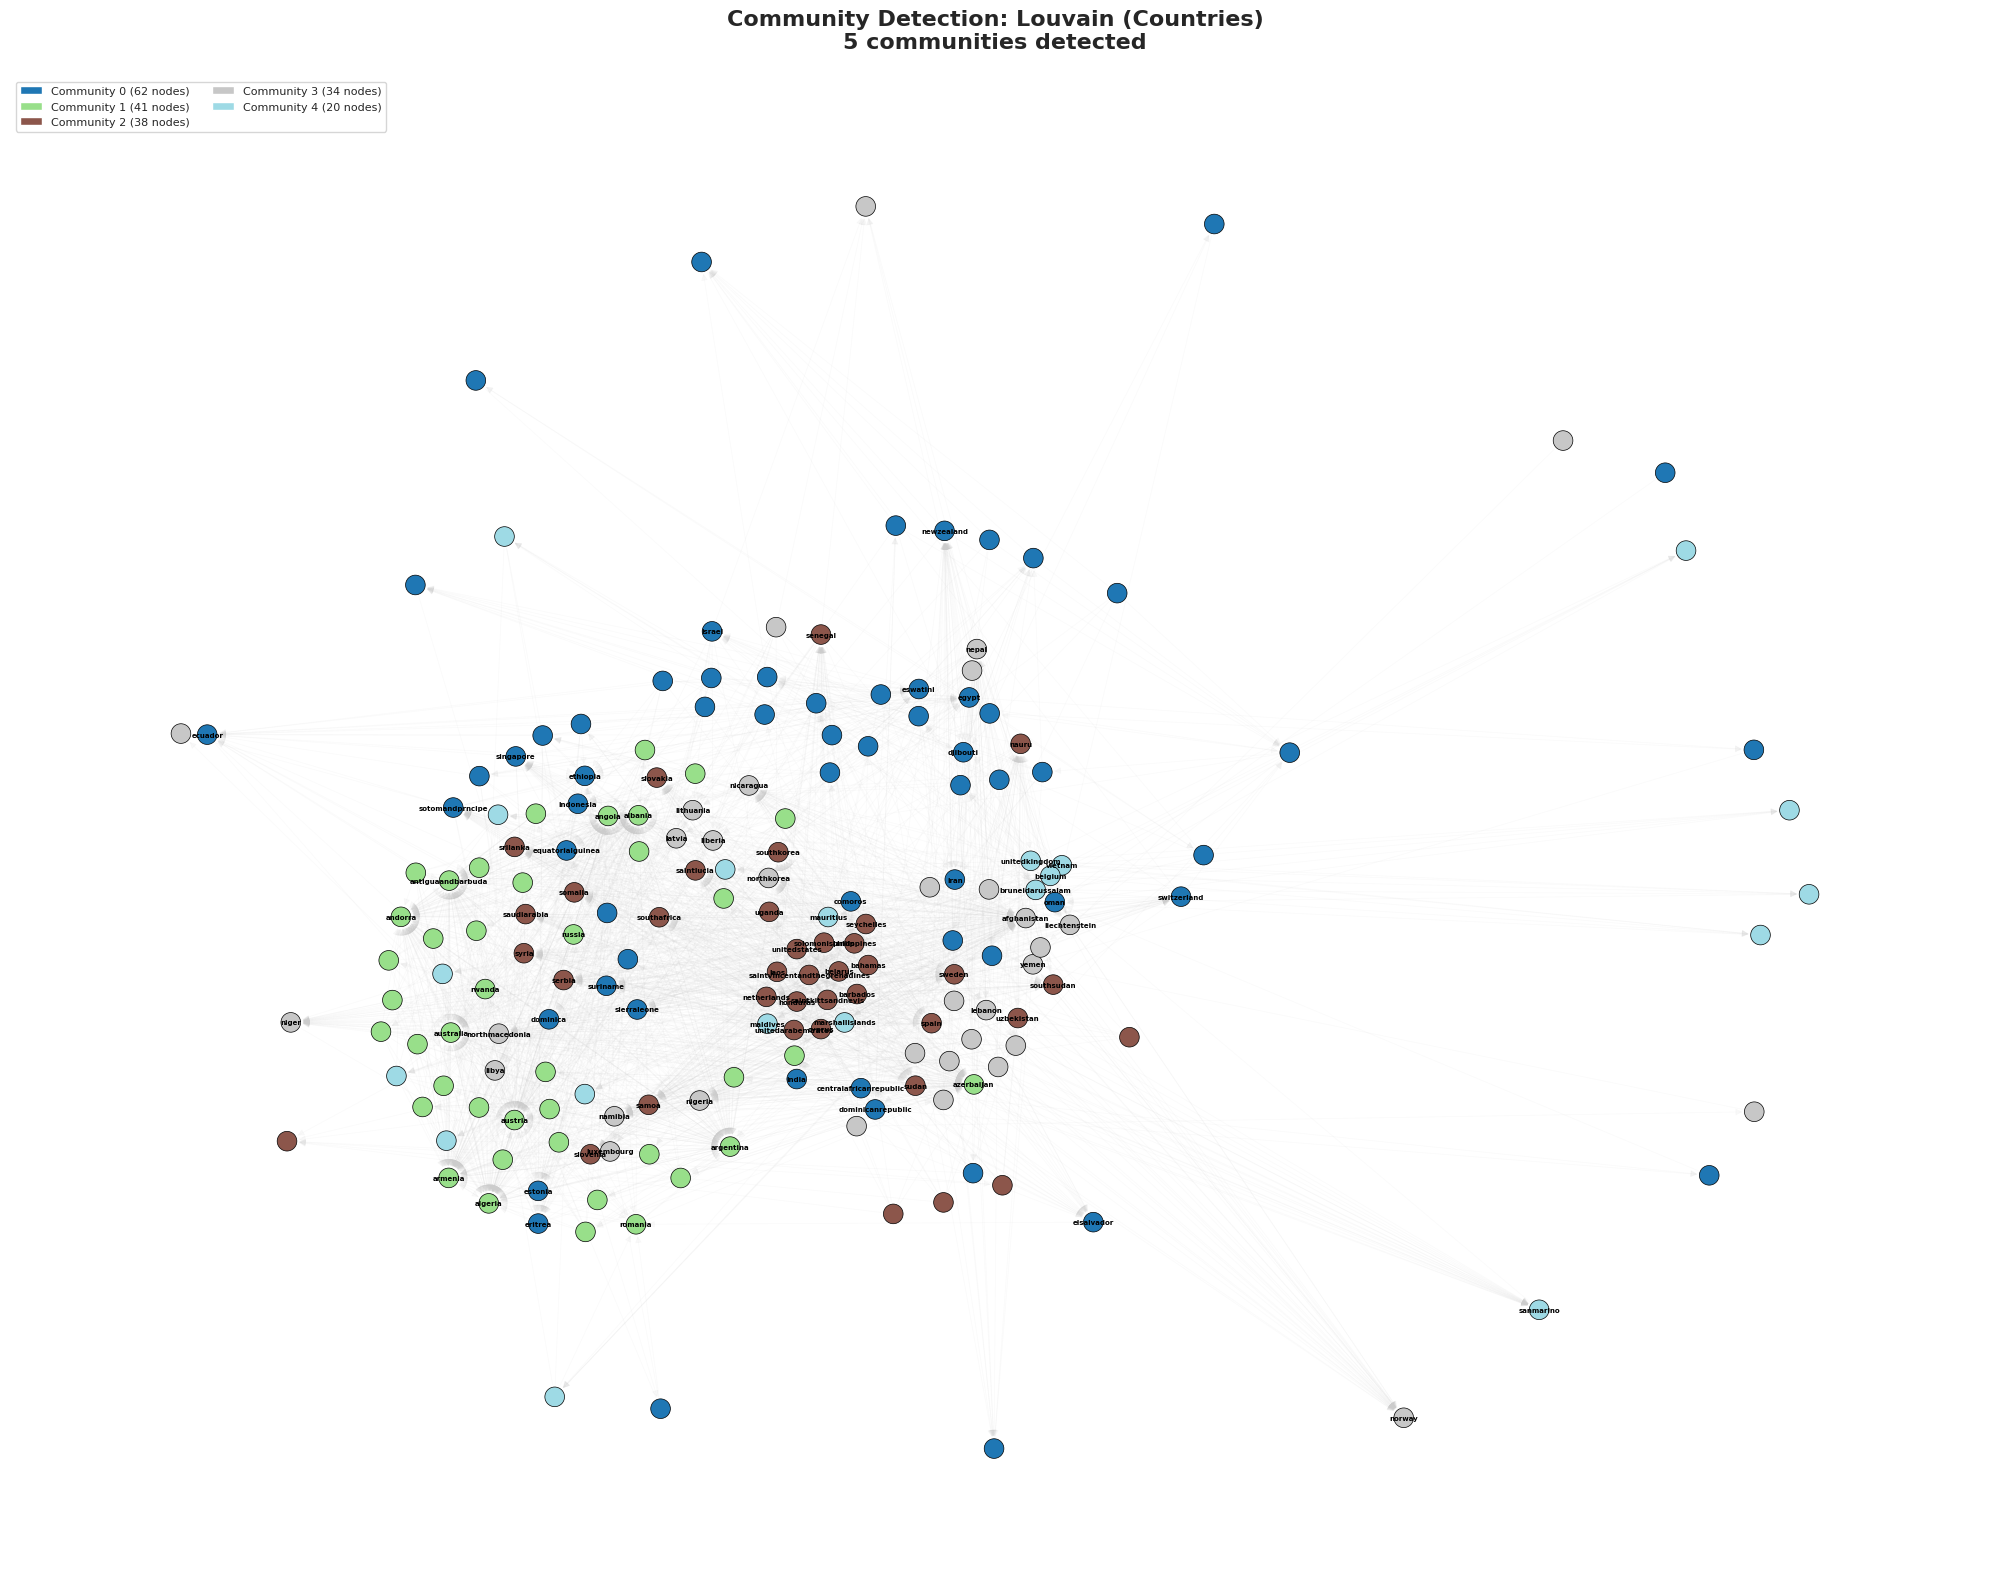

Louvain communities for G_country visualized and saved.


In [64]:
detector.visualize_communities(G_country, partition_louvain, pos_countries, algorithm_name='Louvain (Countries)')
print("Louvain communities for G_country visualized and saved.")

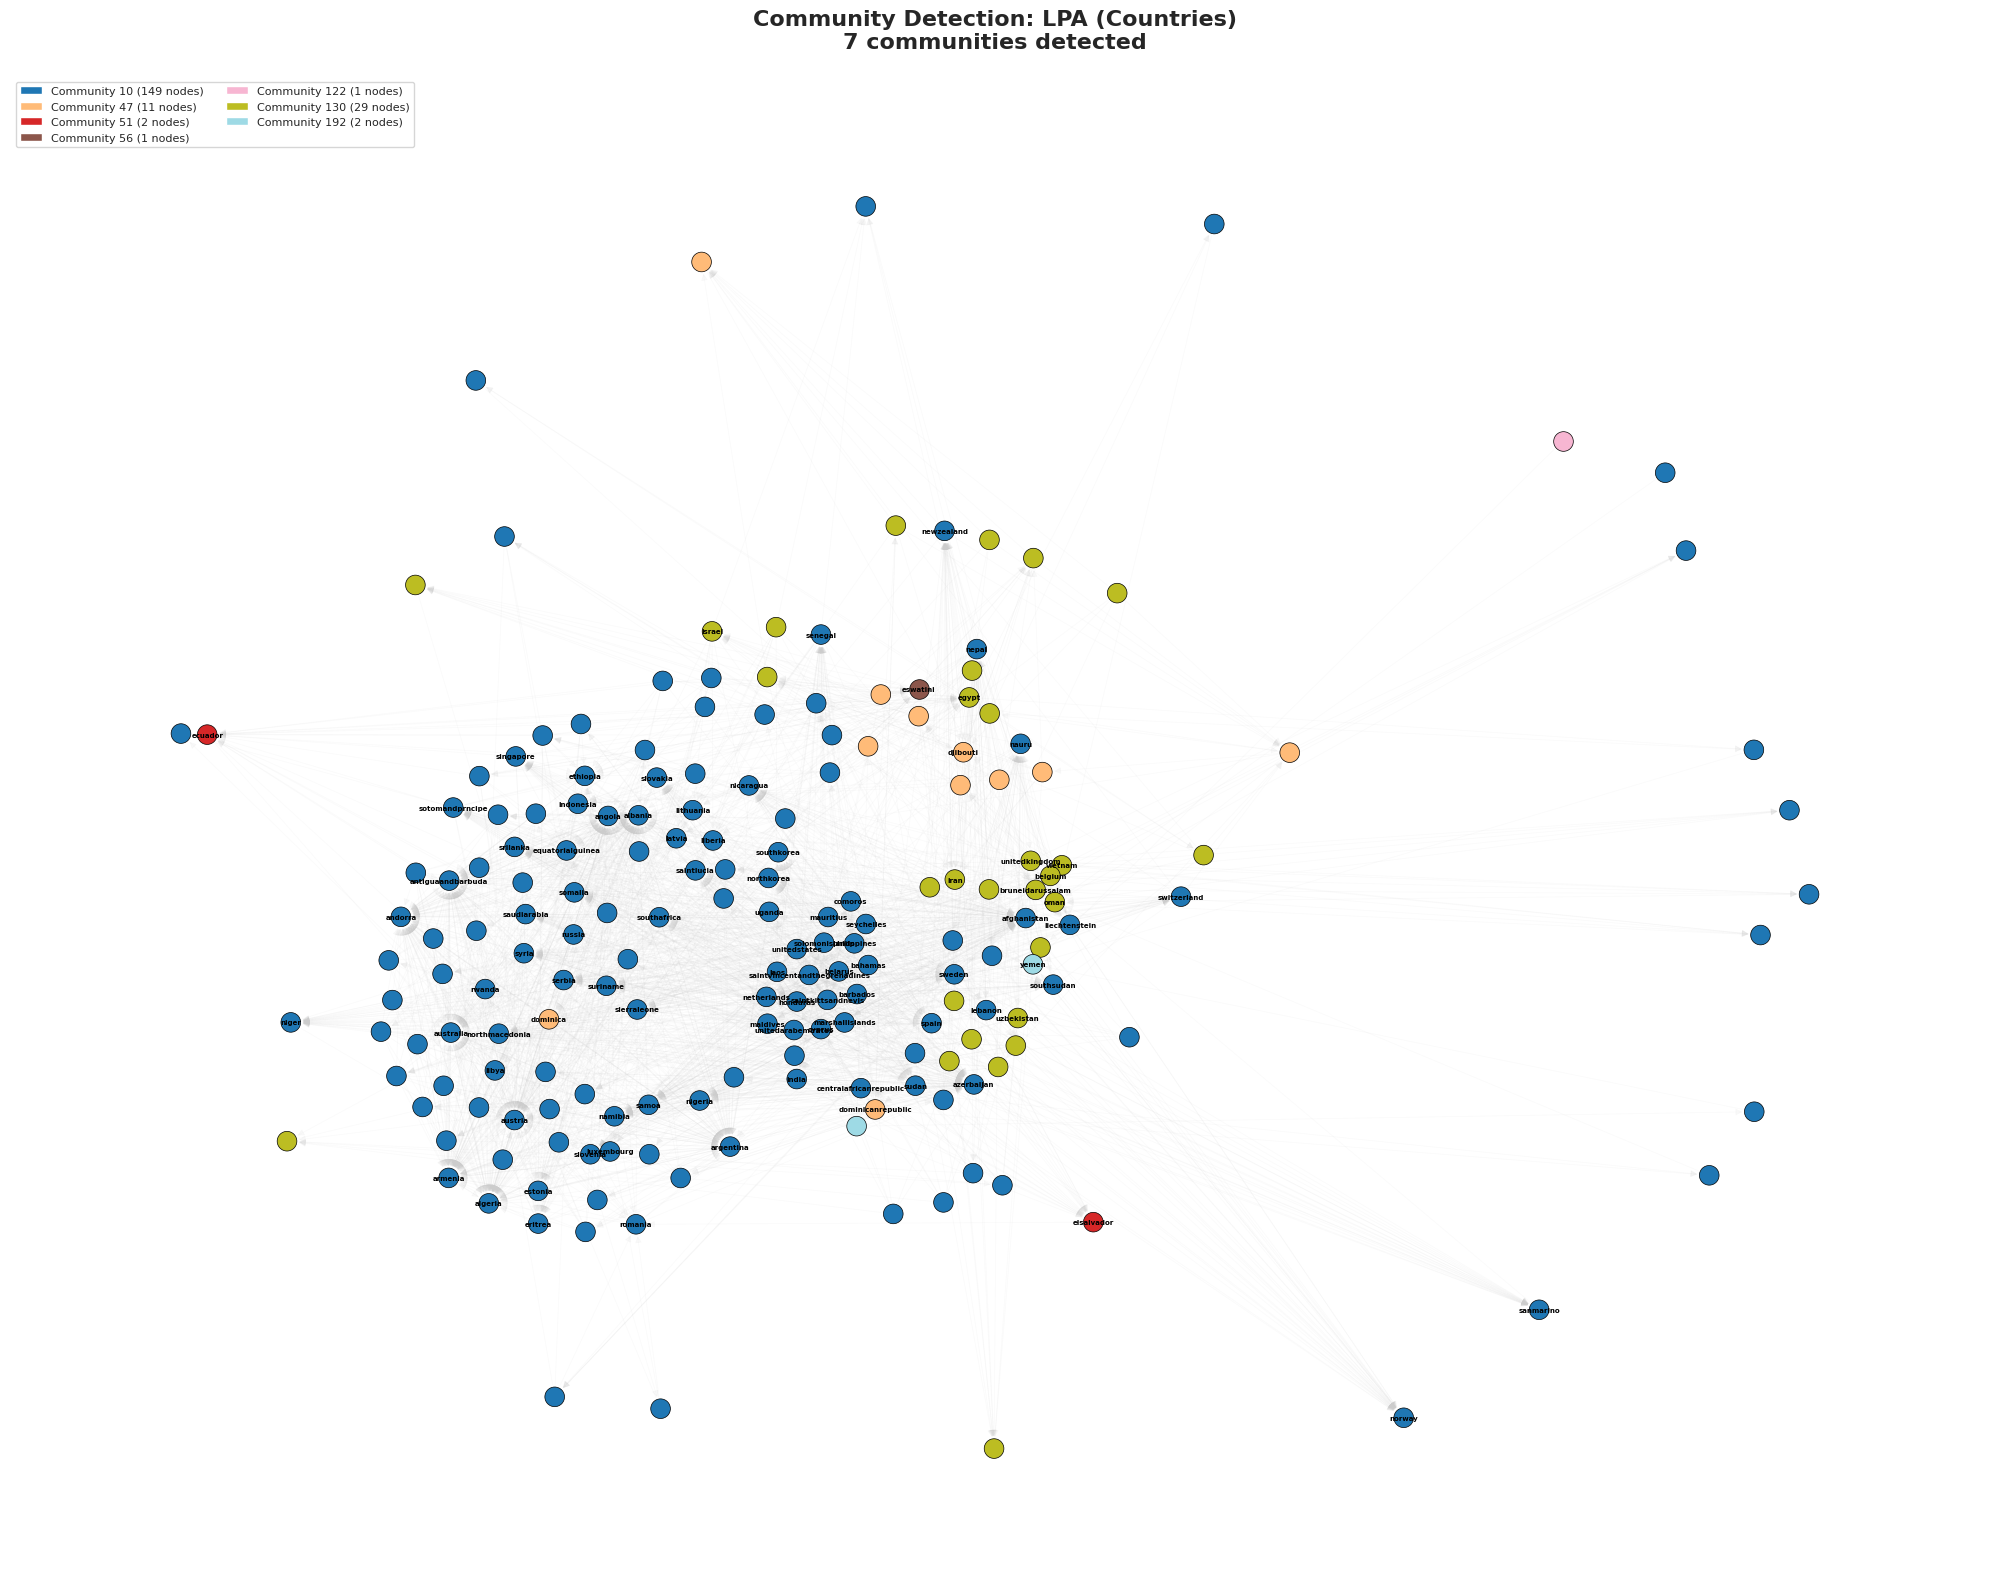

Stabilized Label Propagation communities for G_country visualized and saved.


In [65]:
detector.visualize_communities(G_country, partition_lpa, pos_countries, algorithm_name='LPA (Countries)')
print("Stabilized Label Propagation communities for G_country visualized and saved.")